In [1]:
%matplotlib inline
import xarray as xr
import numpy as np
from time import time
import pickle
import statsmodels.api as sm
from scipy import stats
from sklearn.linear_model import TheilSenRegressor, LinearRegression
import pymannkendall as mk
import mpl_scatter_density # adds projection='scatter_density'
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
from sklearn.inspection import permutation_importance
import pingouin as pg


import cartopy.feature as cfeature
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
plt.rcParams['font.family'] = 'Myriad Pro'
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

path_ = '/home/mizu_home/xp53/nas/home/BEST/TAVG/'
pre_ = 'Complete_TAVG_Daily_LatLong1_'

from ipcc_colormap import *
cmap_prep = ipcc_cmap()
cmap_prep.read_rgb_data_from_excel()
;

''

In [2]:
# i concatenated two chunks of codes here and you may find duplicate variables (t_50 and temp_median)
# but im too lazy to clean it up so bear with me
# read processed data from pkl file
pkl_file = open('NH_winter_temp.pkl', 'rb')
# remove the first 90 rows (JFM of 1980) and the last 61 rows (ND of 2020)
temp = pickle.load(pkl_file)[90:-61, :, :]
climatology = np.mean(temp, axis=0)

temp_mean = np.zeros((39, 90, 360))
temp_median = np.zeros((39, 90, 360))
t_50 = np.zeros((39, 90, 360))
t_95 = np.zeros((39, 90, 360))
t_5 = np.zeros((39, 90, 360))

t_std = np.zeros((39, 90, 360))

for yy in range(39):
    left, right = yy*151, (yy+1)*151

    tmean = np.mean(temp[left:right, :, :], axis=0)
    tmedian = np.median(temp[left:right, :, :], axis=0)
    temp_mean[yy, :, :] = tmean
    temp_median[yy, :, :] = tmedian
    t_std[yy, :, :] = np.std(temp[left:right, :, :], axis=0)

    t50 = np.percentile(temp[left:right, :, :], 50, axis=0)
    t95 = np.percentile(temp[left:right, :, :], 95, axis=0)
    t5 = np.percentile(temp[left:right, :, :], 5, axis=0)
    t_50[yy, :, :] = t50
    t_95[yy, :, :] = t95
    t_5[yy, :, :] = t5

# mask out nan values in temperatures
mask = 1 - np.isnan(np.mean(temp_mean, axis=0))
# the 1-deg mask (mask2) is downscaled from the 2-deg from Gottlieb 2024 et al.
mask2 = np.loadtxt('mask_1deg.txt')
mask = mask * mask2

In [3]:
swe_gridded = np.loadtxt('swe_gridded_1deg.txt')
swe_insitu = np.loadtxt('swe_insitu_1deg.txt')

comp_gridded = []
comp_insitu = []
climatology_group_map = np.zeros((90, 360))

xx = np.arange(39)

cnt = 0
t1 = time() 

for i in range(90):
    for j in range(360):
        if not mask[i, j]:
            continue

        cnt += 1
        if cnt % 1000 == 0:
            print('Processing ', cnt, ' grids. Time taken so far: ', time() - t1)
        
        lm_mean = TheilSenRegressor(random_state=42)
        lm_mean.fit(xx[:,None], temp_mean[:,i,j])

        # 50th, 95th, and 5th percentile trends
        lm50 = TheilSenRegressor(random_state=42)
        lm50.fit(xx[:,None], t_50[:,i,j])

        lm5 = TheilSenRegressor(random_state=42)
        lm5.fit(xx[:,None], t_5[:,i,j])

        lm95 = TheilSenRegressor(random_state=42)
        lm95.fit(xx[:,None], t_95[:,i,j])

        comp_gridded.append((swe_gridded[i,j],
                             lm_mean.coef_[0] * 10,
                             lm50.coef_[0] * 10,
                             (lm5.coef_[0] - lm50.coef_[0]) * 10,
                             (lm95.coef_[0] - lm50.coef_[0]) * 10,
                             climatology[i,j]))
        if swe_insitu[i,j]:
            comp_insitu.append((swe_insitu[i,j],
                             lm_mean.coef_[0] * 10,
                             lm50.coef_[0] * 10,
                             (lm5.coef_[0] - lm50.coef_[0]) * 10,
                             (lm95.coef_[0] - lm50.coef_[0]) * 10,
                             climatology[i,j]))
        if climatology[i,j] <= -20:
            climatology_group_map[i,j] = 1
        elif climatology[i,j] <= -10:
            climatology_group_map[i,j] = 2
        elif climatology[i,j] <= 0:
            climatology_group_map[i,j] = 3
        else:
            climatology_group_map[i,j] = 4

comp_gridded = np.array(comp_gridded)
comp_insitu = np.array(comp_insitu)
# Create mask for rows where March SWE <= 2
mask_gridded = comp_gridded[:, 0] <= 2
comp_gridded = comp_gridded[mask_gridded]

mask_insitu = comp_insitu[:, 0] <= 2
comp_insitu = comp_insitu[mask_insitu]

# comp_gridded[:,0]: Mar SWE trend from Gottlieb et al. 2024
# comp_gridded[:,1]: trend of mean temperature
# comp_gridded[:,2]: trend of median temperature
# comp_gridded[:,3]: cold tail outpacing
# comp_gridded[:,4]: warm tail outpacing
# comp_gridded[:,5]: climatological temperature
# same for comp_insitu        

Processing  1000  grids. Time taken so far:  34.532448291778564
Processing  2000  grids. Time taken so far:  71.05329465866089
Processing  3000  grids. Time taken so far:  107.74761462211609
Processing  4000  grids. Time taken so far:  144.6586537361145
Processing  5000  grids. Time taken so far:  181.69480681419373
Processing  6000  grids. Time taken so far:  220.65800213813782
Processing  7000  grids. Time taken so far:  260.41836953163147


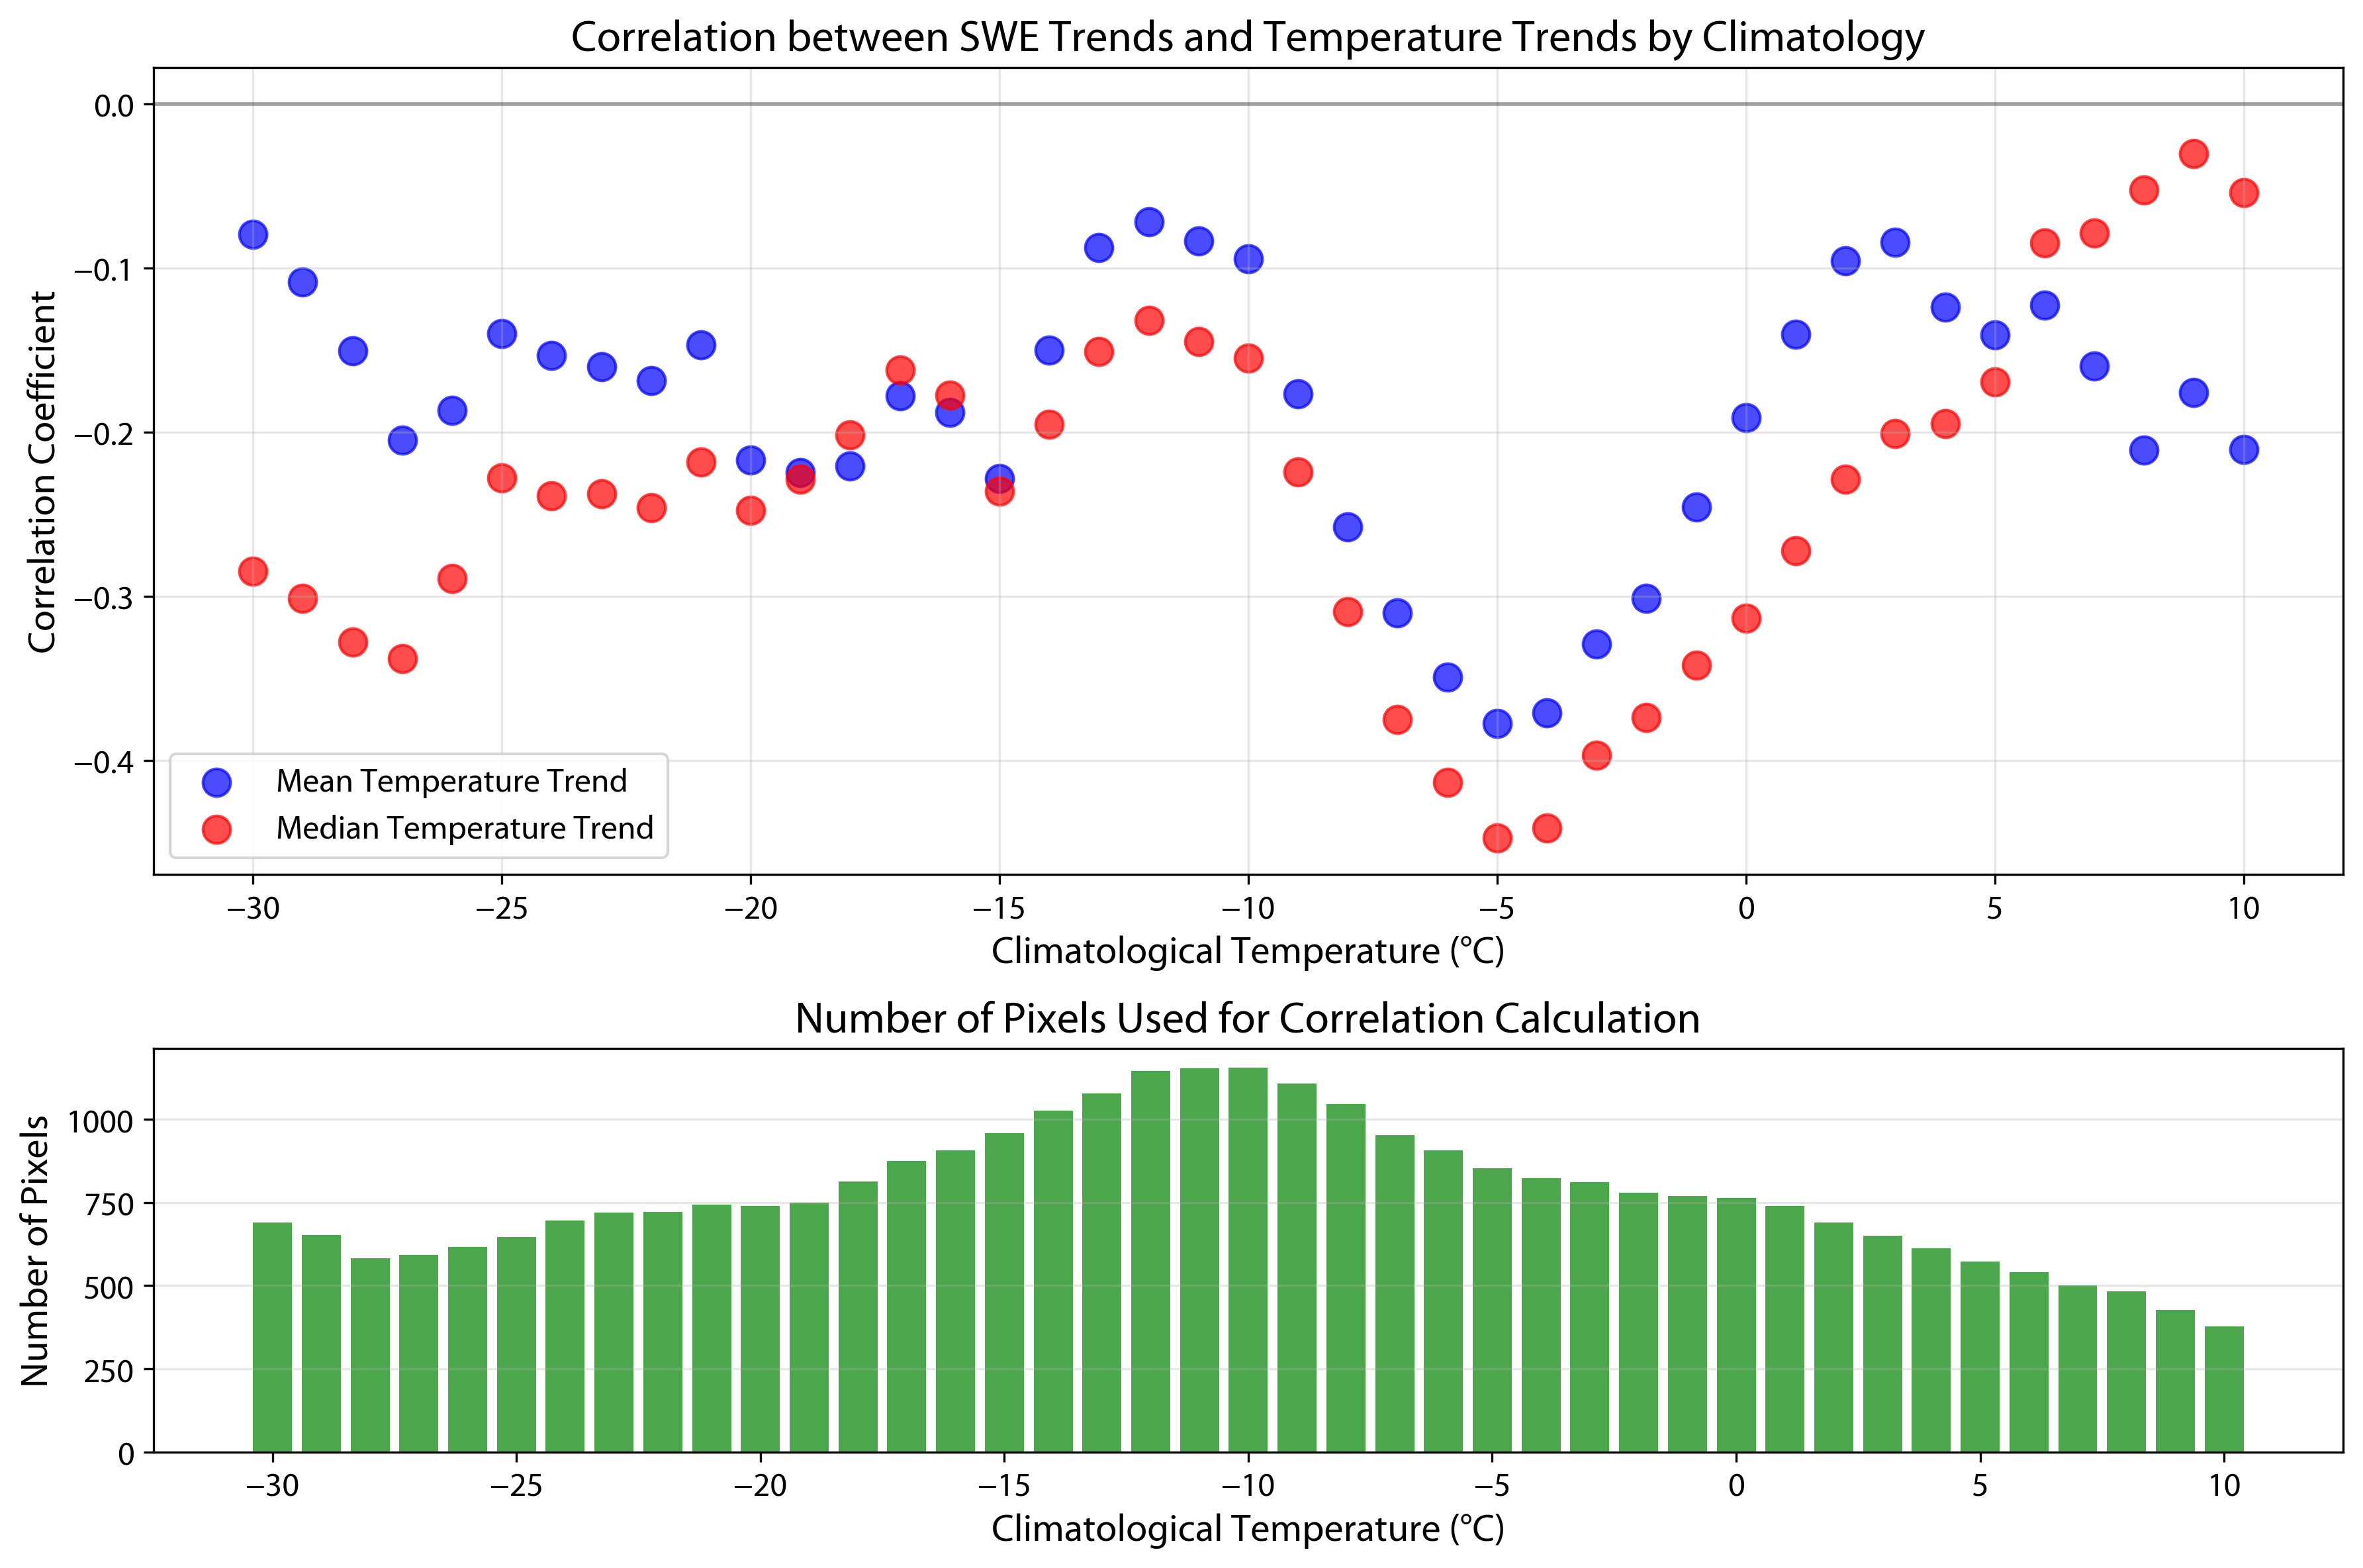

In [4]:
# Define climatology range and window size
clim_range = np.arange(-30, 11, 1)  # From -30 to 10 with step of 1
window_size = 2.5  # +/- window size for climatology values

# Initialize arrays to store correlation coefficients
corr_mean = np.zeros((len(clim_range), 2))  # [climatology, correlation]
corr_median = np.zeros((len(clim_range), 2))  # [climatology, correlation]
pixel_counts = np.zeros(len(clim_range))  # To store number of pixels for each climatology value

# Loop through climatology values
for i, clim_val in enumerate(clim_range):
    # Find pixels with climatology within the window
    mask = (comp_gridded[:, 5] >= clim_val - window_size) & (comp_gridded[:, 5] <= clim_val + window_size)
    
    # Store the number of pixels for this climatology value
    pixel_counts[i] = np.sum(mask)
    
    if np.sum(mask) > 5:  # Ensure we have enough data points for correlation
        # Calculate correlation between SWE trends and temperature trends
        corr_mean[i, 0] = clim_val
        corr_mean[i, 1] = np.corrcoef(comp_gridded[mask, 0], comp_gridded[mask, 1])[0, 1]
        
        corr_median[i, 0] = clim_val
        corr_median[i, 1] = np.corrcoef(comp_gridded[mask, 0], comp_gridded[mask, 2])[0, 1]
    else:
        corr_mean[i, 0] = clim_val
        corr_mean[i, 1] = np.nan
        
        corr_median[i, 0] = clim_val
        corr_median[i, 1] = np.nan

# Remove rows with NaN values
corr_mean = corr_mean[~np.isnan(corr_mean[:, 1])]
corr_median = corr_median[~np.isnan(corr_median[:, 1])]

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), gridspec_kw={'height_ratios': [2, 1]})

# Top panel: Correlation coefficients
ax1.scatter(corr_mean[:, 0], corr_mean[:, 1], label='Mean Temperature Trend', alpha=0.7, color='blue', s=100)
ax1.scatter(corr_median[:, 0], corr_median[:, 1], label='Median Temperature Trend', alpha=0.7, color='red', s=100)

ax1.set_xlabel('Climatological Temperature (°C)', fontsize=14)
ax1.set_ylabel('Correlation Coefficient', fontsize=14)
ax1.set_title('Correlation between SWE Trends and Temperature Trends by Climatology', fontsize=16)
ax1.legend(fontsize=12)
ax1.grid(True, alpha=0.3)
ax1.axhline(y=0, color='k', linestyle='-', alpha=0.3)
ax1.tick_params(axis='both', which='major', labelsize=12)

# Bottom panel: Number of pixels
ax2.bar(clim_range, pixel_counts, width=0.8, alpha=0.7, color='green')
ax2.set_xlabel('Climatological Temperature (°C)', fontsize=14)
ax2.set_ylabel('Number of Pixels', fontsize=14)
ax2.set_title('Number of Pixels Used for Correlation Calculation', fontsize=16)
ax2.grid(True, alpha=0.3, axis='y')
ax2.tick_params(axis='both', which='major', labelsize=12)

plt.tight_layout()
plt.show()


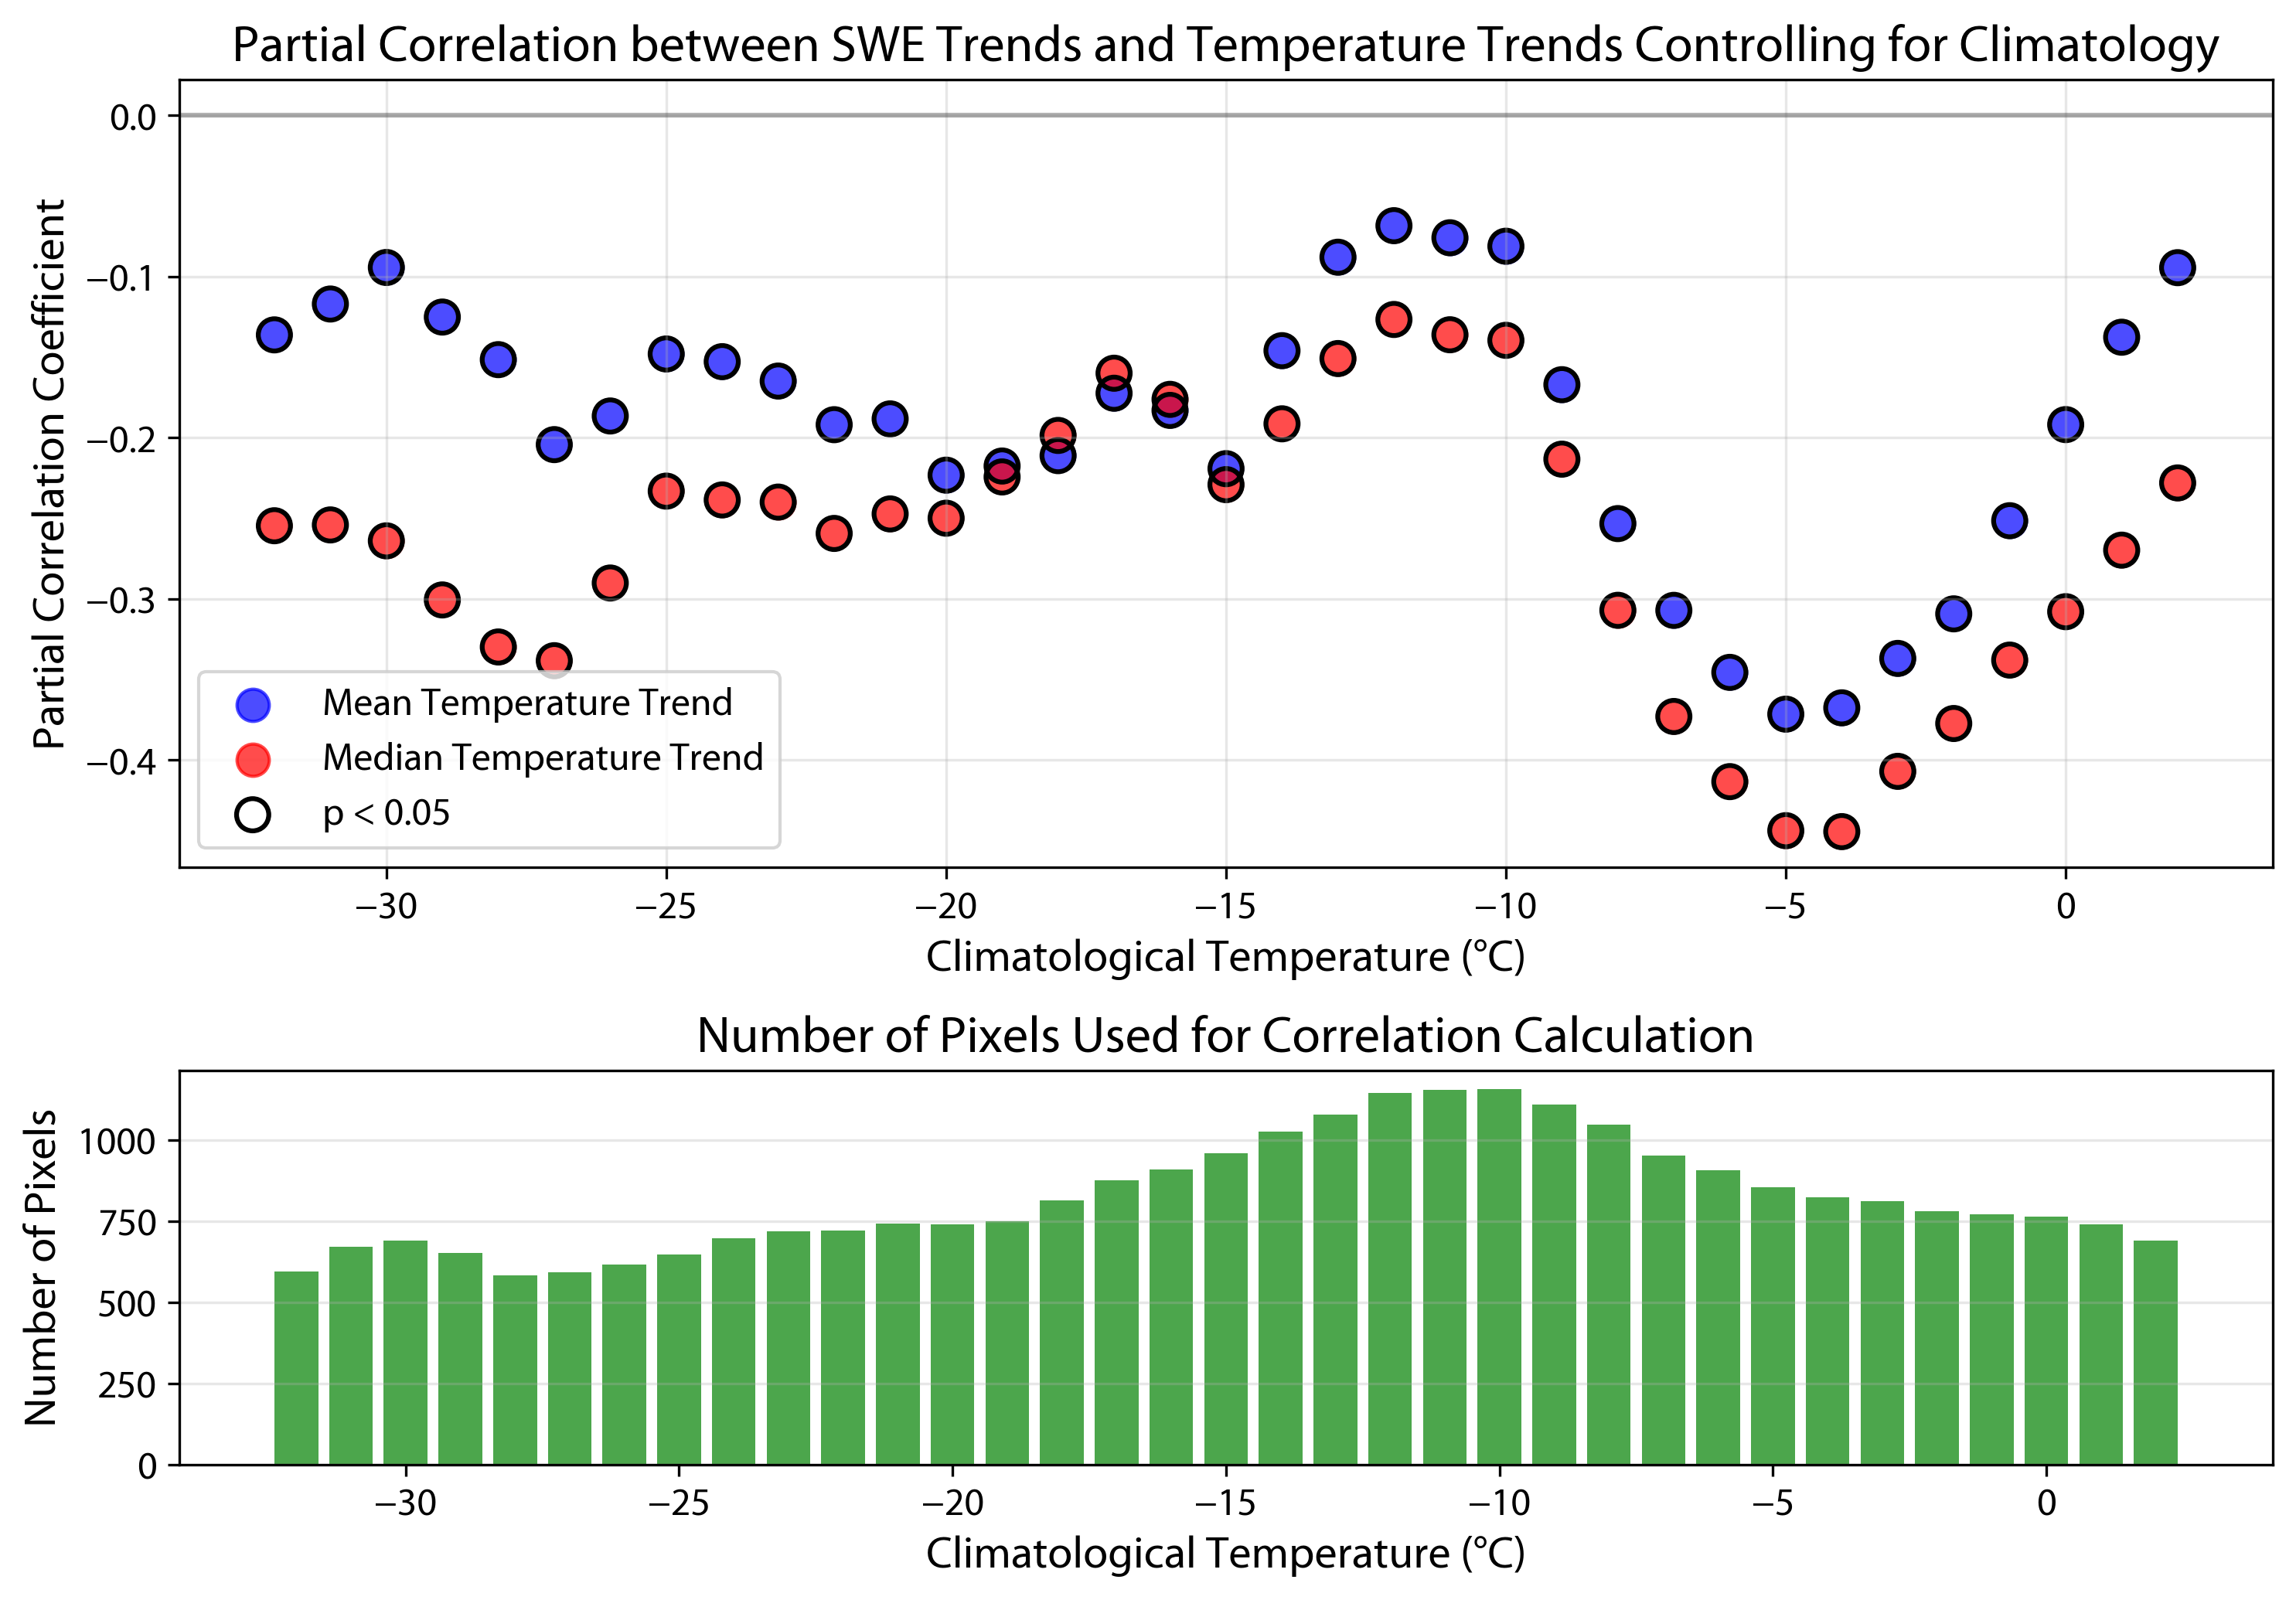

In [ ]:
# Define climatology range and window size
clim_range = np.arange(-32, 3, 1)  # From -30 to 10 with step of 1
window_size = 2.5 # +/- window size for climatology values

# Initialize arrays to store correlation coefficients
corr_mean = np.zeros((len(clim_range), 3))  # [climatology, correlation, p-value]
corr_median = np.zeros((len(clim_range), 3))  # [climatology, correlation, p-value]
pixel_counts = np.zeros(len(clim_range))  # To store number of pixels for each climatology value

# Loop through climatology values
for i, clim_val in enumerate(clim_range):
    # Find pixels with climatology within the window
    mask = (comp_gridded[:, 5] >= clim_val - window_size) & (comp_gridded[:, 5] <= clim_val + window_size)
    
    # Store the number of pixels for this climatology value
    pixel_counts[i] = np.sum(mask)
    
    if np.sum(mask) > 5:  # Ensure we have enough data points for correlation
        # Calculate partial correlation between SWE trends and temperature trends, controlling for climatology
        # For mean temperature trend
        X = comp_gridded[mask, 0]  # SWE trends
        Y = comp_gridded[mask, 1]  # Mean temperature trends
        Z = comp_gridded[mask, 5]  # Climatology
        
        # Calculate partial correlation using pingouin
        partial_corr_result_mean = pg.partial_corr(data=pd.DataFrame({'X': X, 'Y': Y, 'Z': Z}), 
                                           x='X', y='Y', covar='Z').iloc[0]
        
        # For median temperature trend
        Y_median = comp_gridded[mask, 2]  # Median temperature trends
        partial_corr_result_median = pg.partial_corr(data=pd.DataFrame({'X': X, 'Y': Y_median, 'Z': Z}), 
                                             x='X', y='Y', covar='Z').iloc[0]
        
        corr_mean[i, 0] = clim_val
        corr_mean[i, 1] = partial_corr_result_mean['r']
        corr_mean[i, 2] = partial_corr_result_mean['p-val']
        
        corr_median[i, 0] = clim_val
        corr_median[i, 1] = partial_corr_result_median['r']
        corr_median[i, 2] = partial_corr_result_median['p-val']
    else:
        corr_mean[i, 0] = clim_val
        corr_mean[i, 1] = np.nan
        corr_mean[i, 2] = np.nan
        
        corr_median[i, 0] = clim_val
        corr_median[i, 1] = np.nan
        corr_median[i, 2] = np.nan

# Remove rows with NaN values
valid_mean = ~np.isnan(corr_mean[:, 1])
valid_median = ~np.isnan(corr_median[:, 1])



# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 7), gridspec_kw={'height_ratios': [2, 1]})

# Top panel: Partial correlation coefficients
# Plot all points
ax1.scatter(corr_mean[valid_mean, 0], corr_mean[valid_mean, 1], label='Mean Temperature Trend', alpha=0.7, color='blue', s=100)
ax1.scatter(corr_median[valid_median, 0], corr_median[valid_median, 1], label='Median Temperature Trend', alpha=0.7, color='red', s=100)

# Highlight significant points (p < 0.05)
significant_mean = (corr_mean[:, 2] < 0.05) & valid_mean
significant_median = (corr_median[:, 2] < 0.05) & valid_median

ax1.scatter(corr_mean[significant_mean, 0], corr_mean[significant_mean, 1], 
           color='black', s=100, facecolors='none', linewidth=1.5, 
           label='p < 0.05')
ax1.scatter(corr_median[significant_median, 0], corr_median[significant_median, 1], 
           color='black', s=100, facecolors='none', linewidth=1.5)

ax1.set_xlabel('Climatological Temperature (°C)', fontsize=14)
ax1.set_ylabel('Partial Correlation Coefficient', fontsize=14)
ax1.set_title('Partial Correlation between SWE Trends and Temperature Trends Controlling for Climatology', fontsize=16)
ax1.legend(fontsize=12)
ax1.grid(True, alpha=0.3)
ax1.axhline(y=0, color='k', linestyle='-', alpha=0.3)
ax1.tick_params(axis='both', which='major', labelsize=12)

# Bottom panel: Number of pixels
ax2.bar(clim_range, pixel_counts, width=0.8, alpha=0.7, color='green')
ax2.set_xlabel('Climatological Temperature (°C)', fontsize=14)
ax2.set_ylabel('Number of Pixels', fontsize=14)
ax2.set_title('Number of Pixels Used for Correlation Calculation', fontsize=16)
ax2.grid(True, alpha=0.3, axis='y')
ax2.tick_params(axis='both', which='major', labelsize=12)

plt.tight_layout()
plt.show()




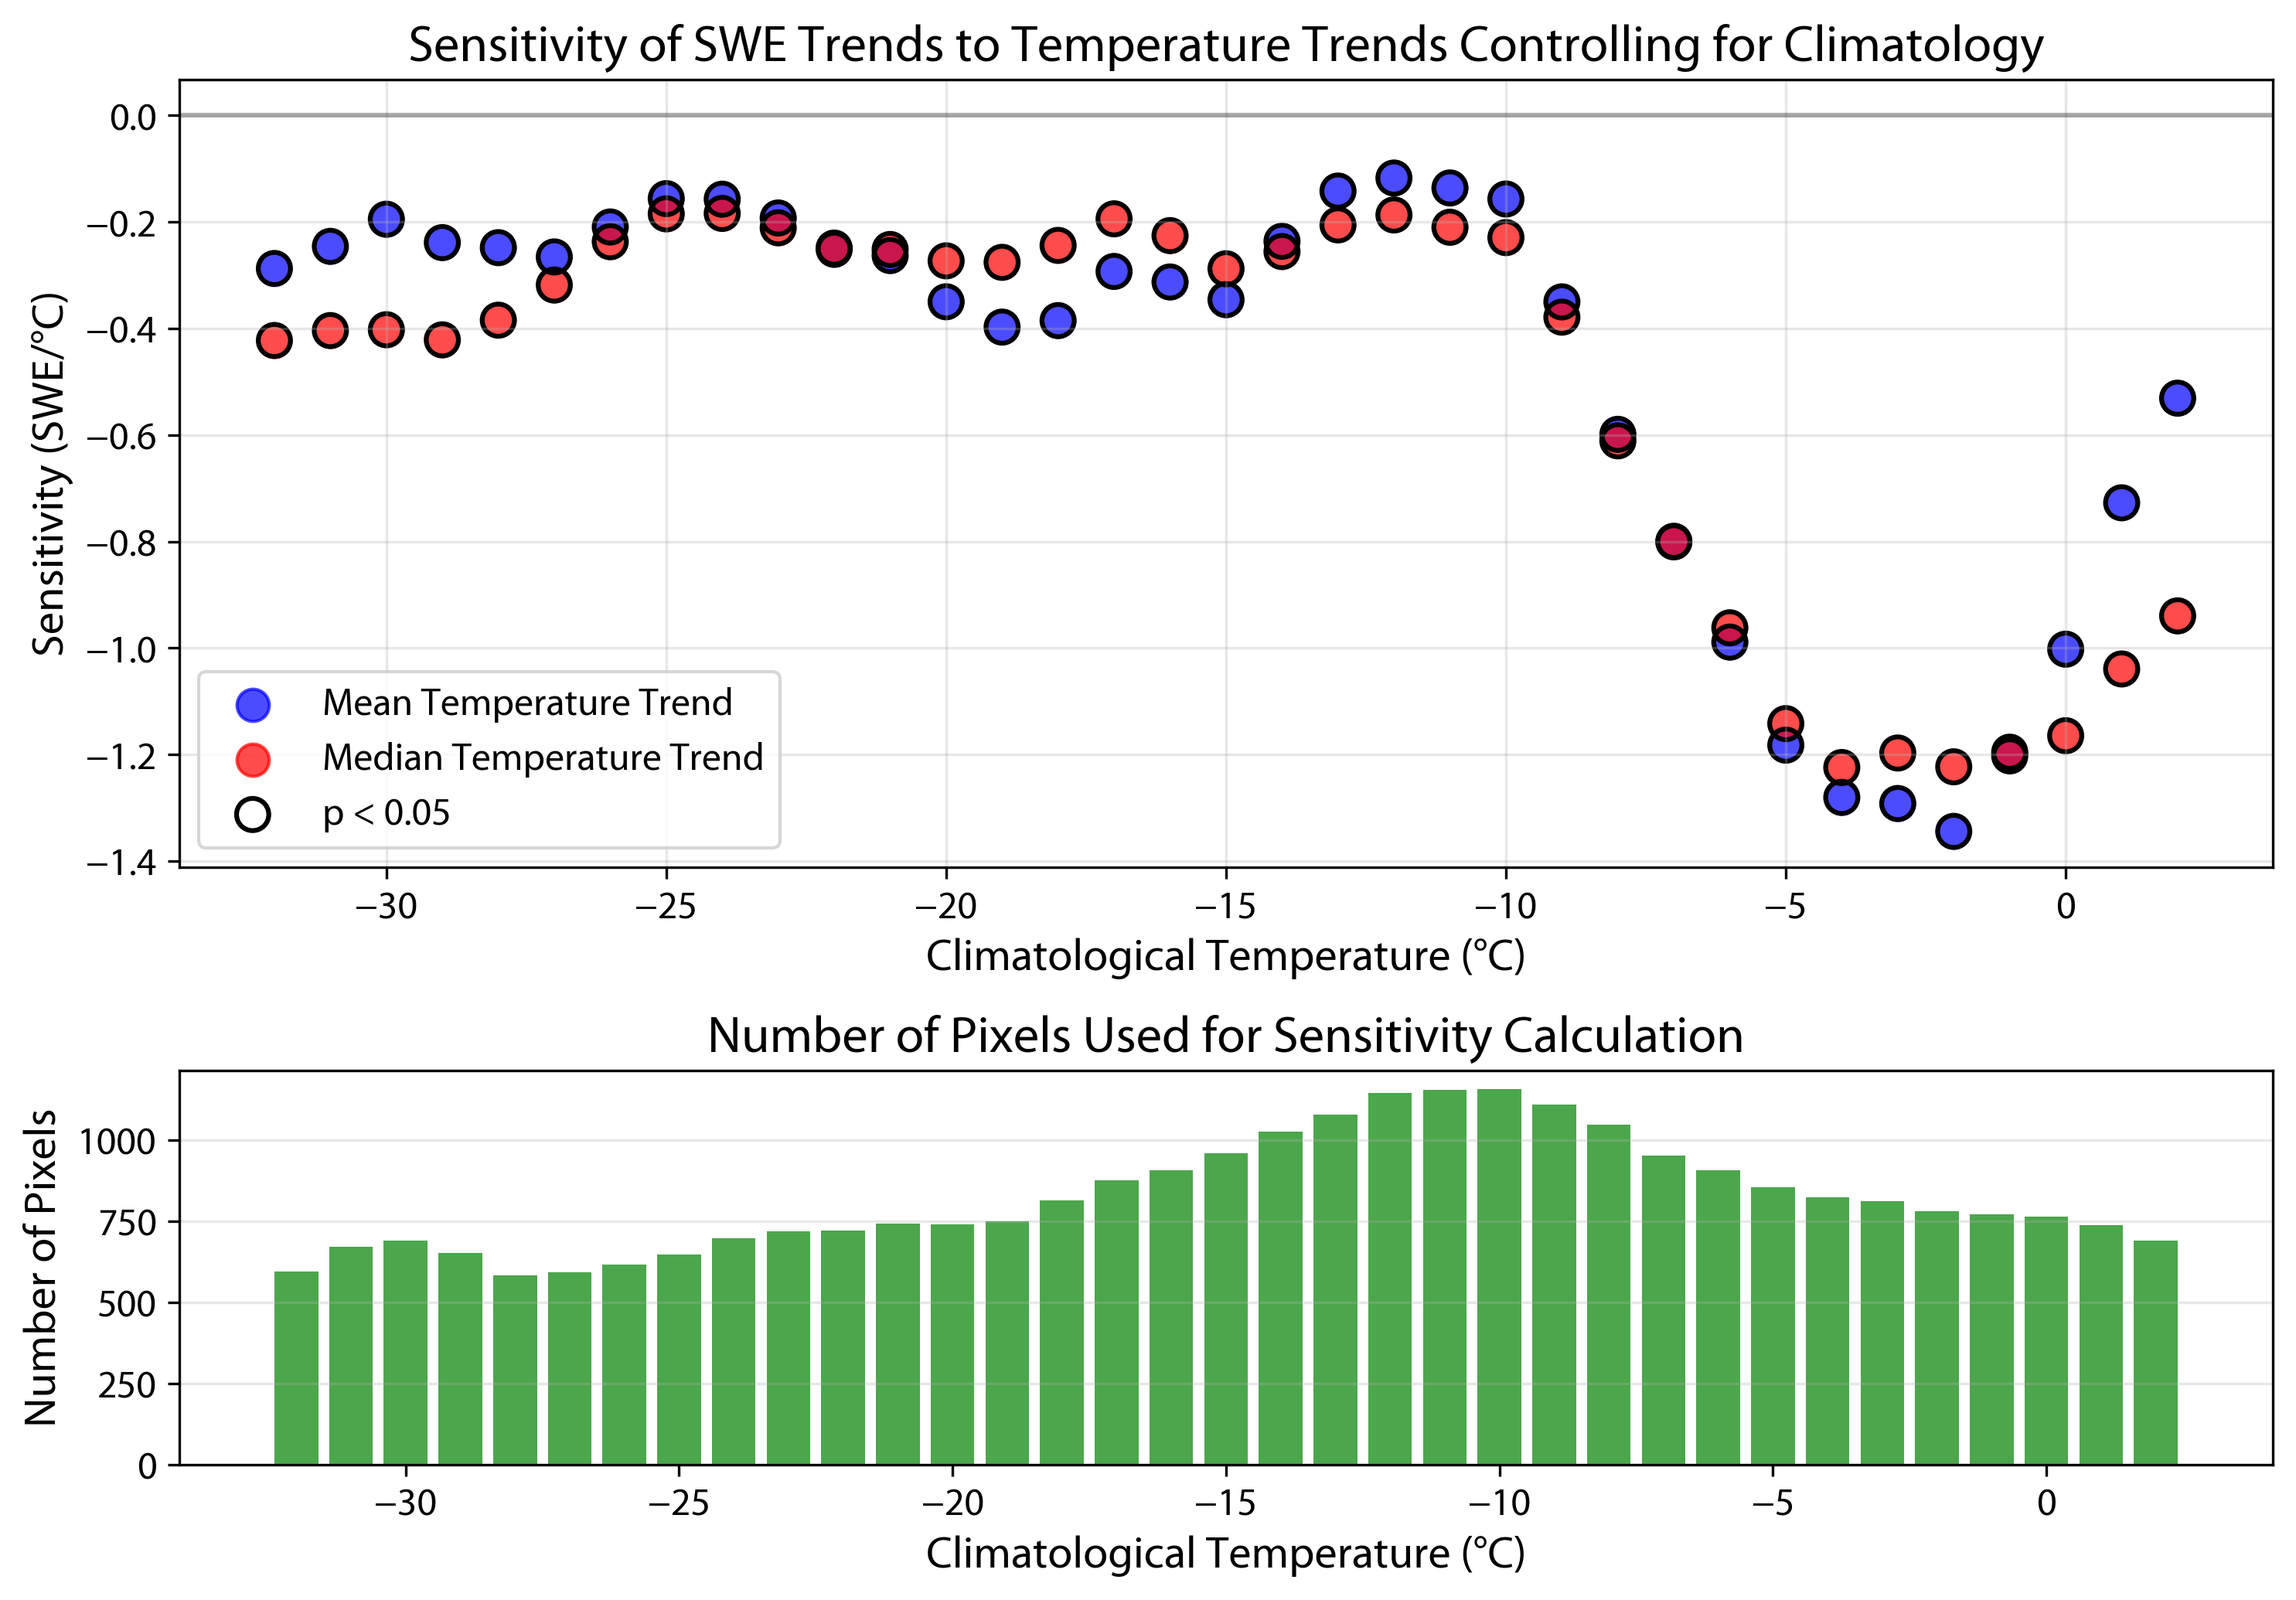

In [12]:
# Define climatology range and window size
clim_range = np.arange(-32, 3, 1)  # From -30 to 10 with step of 1
window_size = 2.5 # +/- window size for climatology values

# Initialize arrays to store correlation coefficients and sensitivities
corr_mean = np.zeros((len(clim_range), 3))  # [climatology, correlation, p-value]
corr_median = np.zeros((len(clim_range), 3))  # [climatology, correlation, p-value]
sens_mean = np.zeros((len(clim_range), 3))  # [climatology, sensitivity, p-value]
sens_median = np.zeros((len(clim_range), 3))  # [climatology, sensitivity, p-value]
pixel_counts = np.zeros(len(clim_range))  # To store number of pixels for each climatology value

# Loop through climatology values
for i, clim_val in enumerate(clim_range):
    # Find pixels with climatology within the window
    mask = (comp_gridded[:, 5] >= clim_val - window_size) & (comp_gridded[:, 5] <= clim_val + window_size)
    
    # Store the number of pixels for this climatology value
    pixel_counts[i] = np.sum(mask)
    
    if np.sum(mask) > 5:  # Ensure we have enough data points for correlation
        # Calculate partial correlation between SWE trends and temperature trends, controlling for climatology
        # For mean temperature trend
        X = comp_gridded[mask, 0]  # SWE trends
        Y = comp_gridded[mask, 1]  # Mean temperature trends
        Z = comp_gridded[mask, 5]  # Climatology
        
        # Calculate partial correlation using pingouin
        partial_corr_result_mean = pg.partial_corr(data=pd.DataFrame({'X': X, 'Y': Y, 'Z': Z}), 
                                           x='X', y='Y', covar='Z').iloc[0]
        
        # For median temperature trend
        Y_median = comp_gridded[mask, 2]  # Median temperature trends
        partial_corr_result_median = pg.partial_corr(data=pd.DataFrame({'X': X, 'Y': Y_median, 'Z': Z}), 
                                             x='X', y='Y', covar='Z').iloc[0]
        
        # Calculate standard deviations for sensitivity calculation
        sigma_SWE = np.std(X)
        sigma_temp_mean = np.std(Y)
        sigma_temp_median = np.std(Y_median)
        
        # Calculate sensitivities: sensitivity = correlation * (sigma_SWE / sigma_temp)
        sensitivity_mean = partial_corr_result_mean['r'] * (sigma_SWE / sigma_temp_mean)
        sensitivity_median = partial_corr_result_median['r'] * (sigma_SWE / sigma_temp_median)
        
        corr_mean[i, 0] = clim_val
        corr_mean[i, 1] = partial_corr_result_mean['r']
        corr_mean[i, 2] = partial_corr_result_mean['p-val']
        
        corr_median[i, 0] = clim_val
        corr_median[i, 1] = partial_corr_result_median['r']
        corr_median[i, 2] = partial_corr_result_median['p-val']
        
        sens_mean[i, 0] = clim_val
        sens_mean[i, 1] = sensitivity_mean
        sens_mean[i, 2] = partial_corr_result_mean['p-val']
        
        sens_median[i, 0] = clim_val
        sens_median[i, 1] = sensitivity_median
        sens_median[i, 2] = partial_corr_result_median['p-val']
    else:
        corr_mean[i, 0] = clim_val
        corr_mean[i, 1] = np.nan
        corr_mean[i, 2] = np.nan
        
        corr_median[i, 0] = clim_val
        corr_median[i, 1] = np.nan
        corr_median[i, 2] = np.nan
        
        sens_mean[i, 0] = clim_val
        sens_mean[i, 1] = np.nan
        sens_mean[i, 2] = np.nan
        
        sens_median[i, 0] = clim_val
        sens_median[i, 1] = np.nan
        sens_median[i, 2] = np.nan

# Remove rows with NaN values
valid_mean = ~np.isnan(sens_mean[:, 1])
valid_median = ~np.isnan(sens_median[:, 1])

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 7), gridspec_kw={'height_ratios': [2, 1]})

# Top panel: Sensitivities (SWE trends to temperature trends)
# Plot all points
ax1.scatter(sens_mean[valid_mean, 0], sens_mean[valid_mean, 1], label='Mean Temperature Trend', alpha=0.7, color='blue', s=100)
ax1.scatter(sens_median[valid_median, 0], sens_median[valid_median, 1], label='Median Temperature Trend', alpha=0.7, color='red', s=100)

# Highlight significant points (p < 0.05)
significant_mean = (sens_mean[:, 2] < 0.05) & valid_mean
significant_median = (sens_median[:, 2] < 0.05) & valid_median

ax1.scatter(sens_mean[significant_mean, 0], sens_mean[significant_mean, 1], 
           color='black', s=100, facecolors='none', linewidth=1.5, 
           label='p < 0.05')
ax1.scatter(sens_median[significant_median, 0], sens_median[significant_median, 1], 
           color='black', s=100, facecolors='none', linewidth=1.5)

ax1.set_xlabel('Climatological Temperature (°C)', fontsize=14)
ax1.set_ylabel('Sensitivity (SWE/°C)', fontsize=14)
ax1.set_title('Sensitivity of SWE Trends to Temperature Trends Controlling for Climatology', fontsize=16)
ax1.legend(fontsize=12)
ax1.grid(True, alpha=0.3)
ax1.axhline(y=0, color='k', linestyle='-', alpha=0.3)
ax1.tick_params(axis='both', which='major', labelsize=12)

# Bottom panel: Number of pixels
ax2.bar(clim_range, pixel_counts, width=0.8, alpha=0.7, color='green')
ax2.set_xlabel('Climatological Temperature (°C)', fontsize=14)
ax2.set_ylabel('Number of Pixels', fontsize=14)
ax2.set_title('Number of Pixels Used for Sensitivity Calculation', fontsize=16)
ax2.grid(True, alpha=0.3, axis='y')
ax2.tick_params(axis='both', which='major', labelsize=12)

plt.tight_layout()
plt.show()


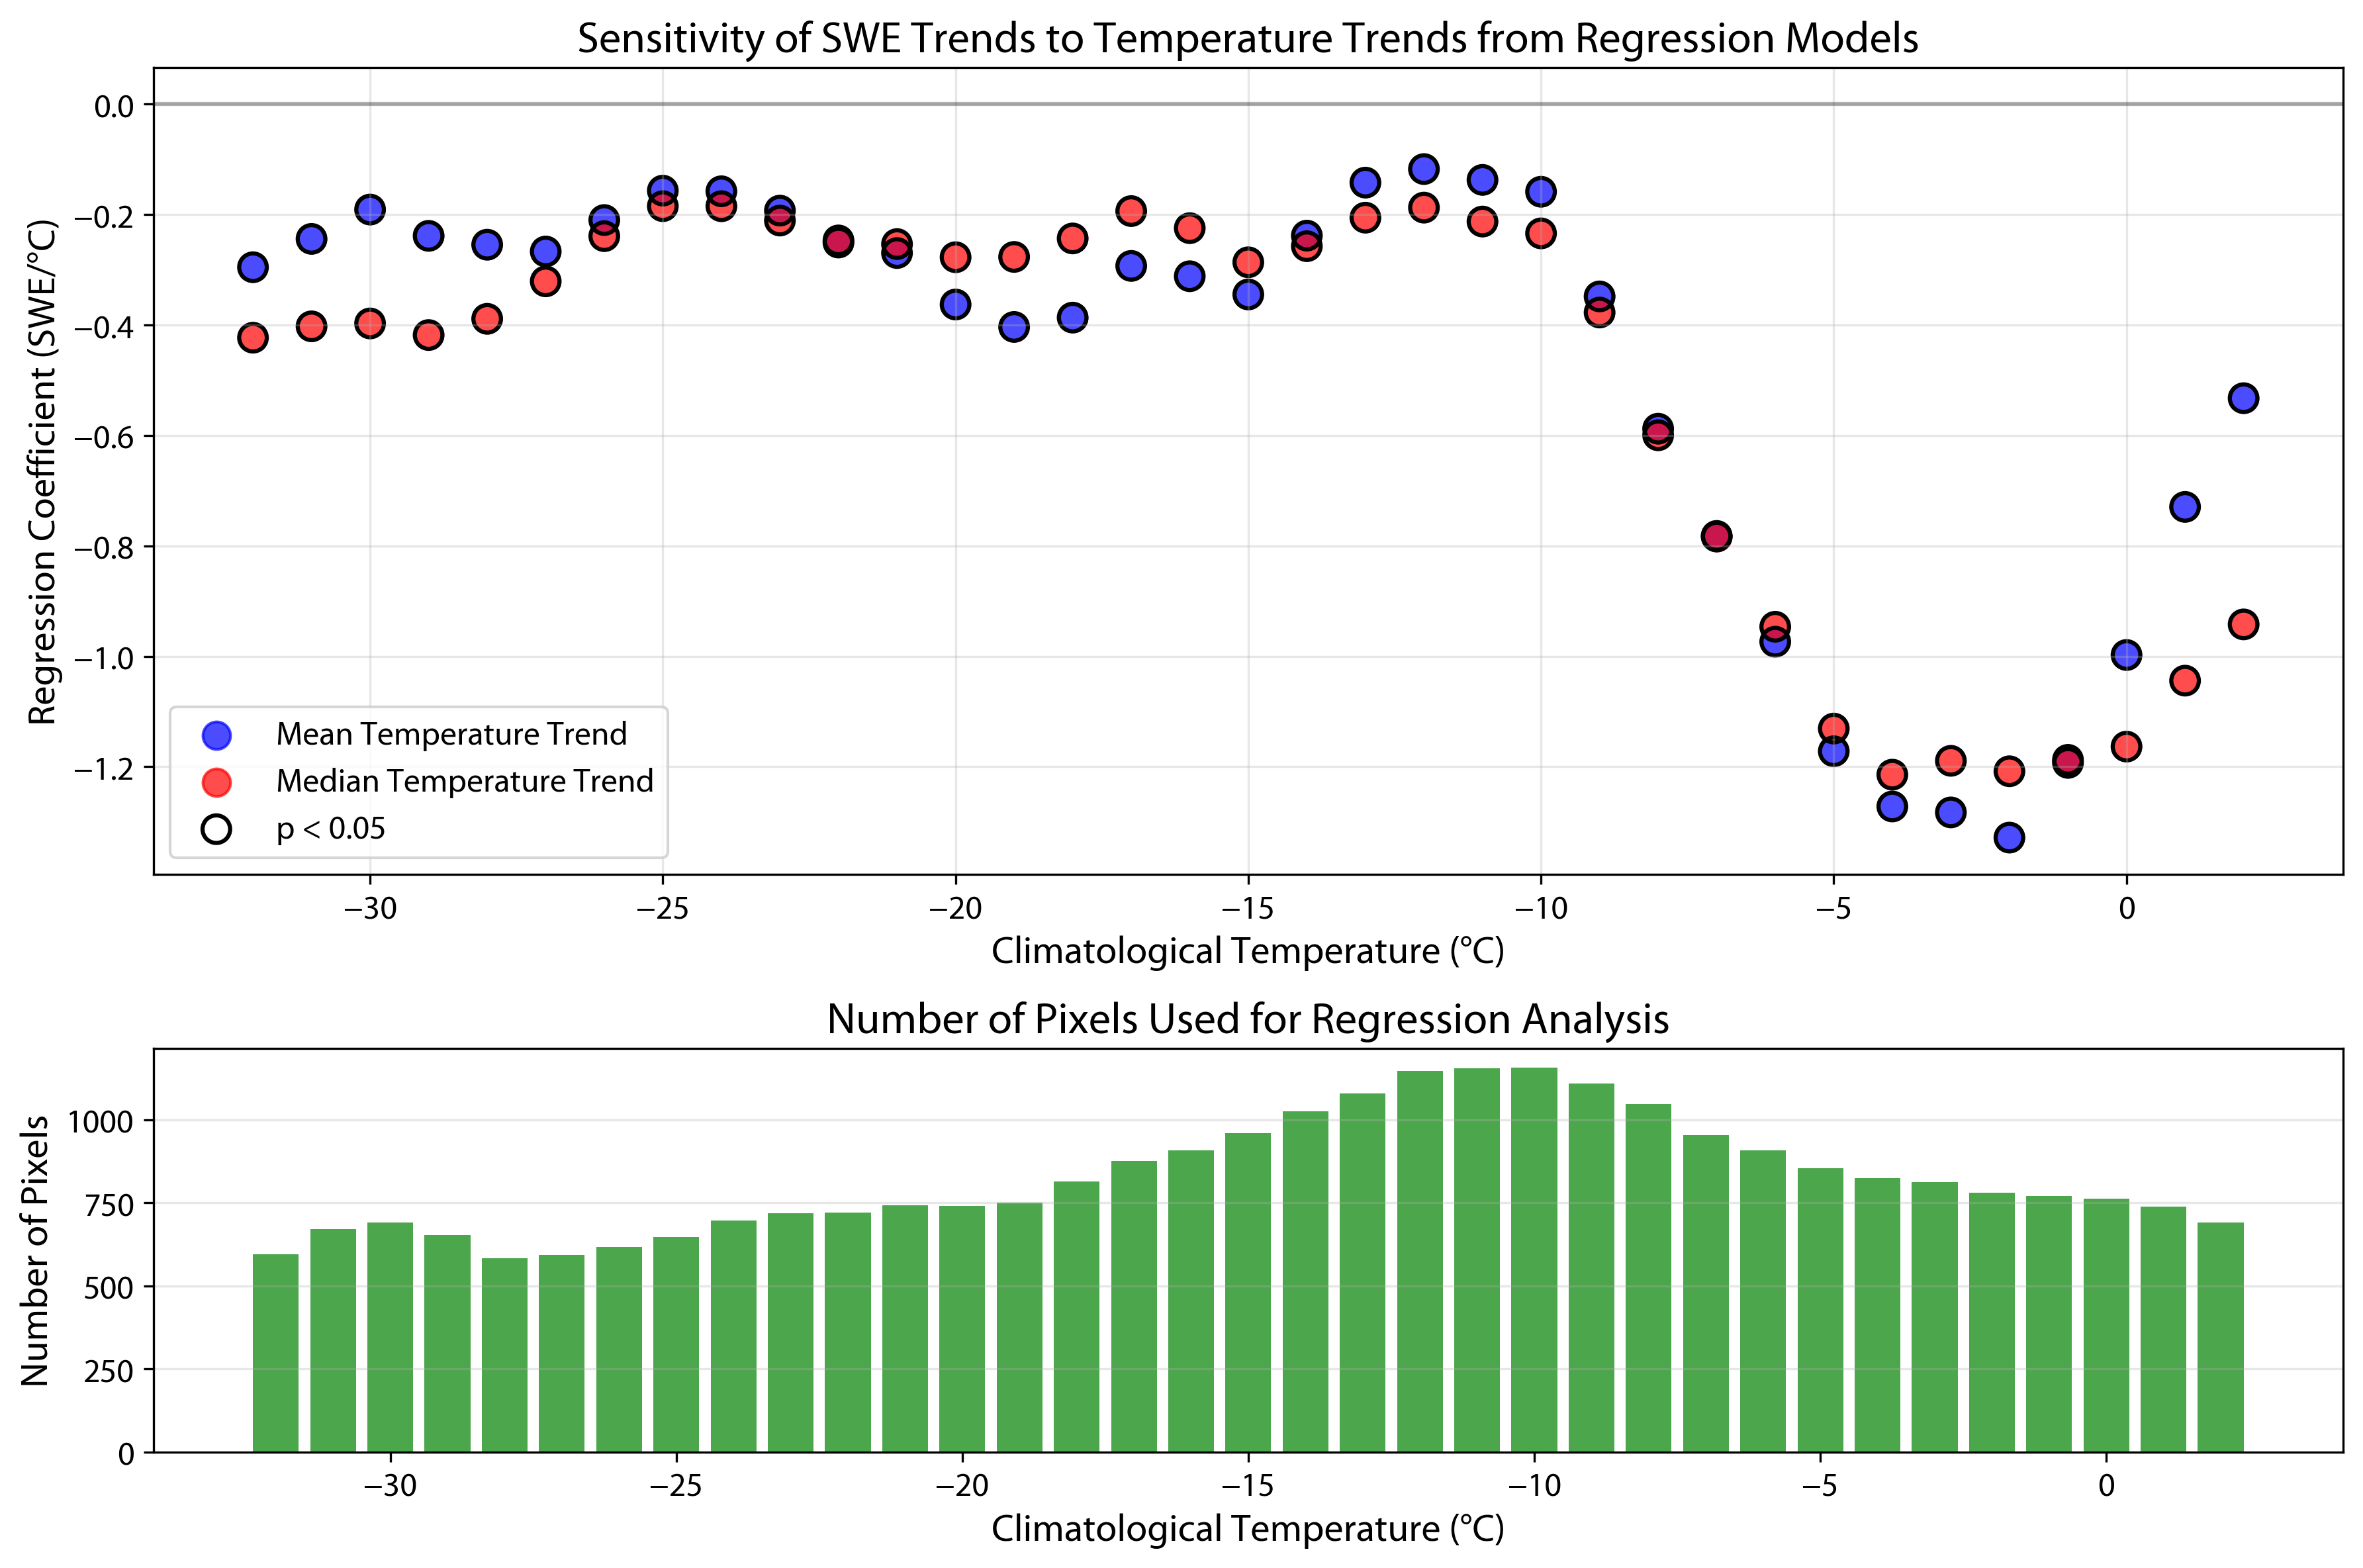

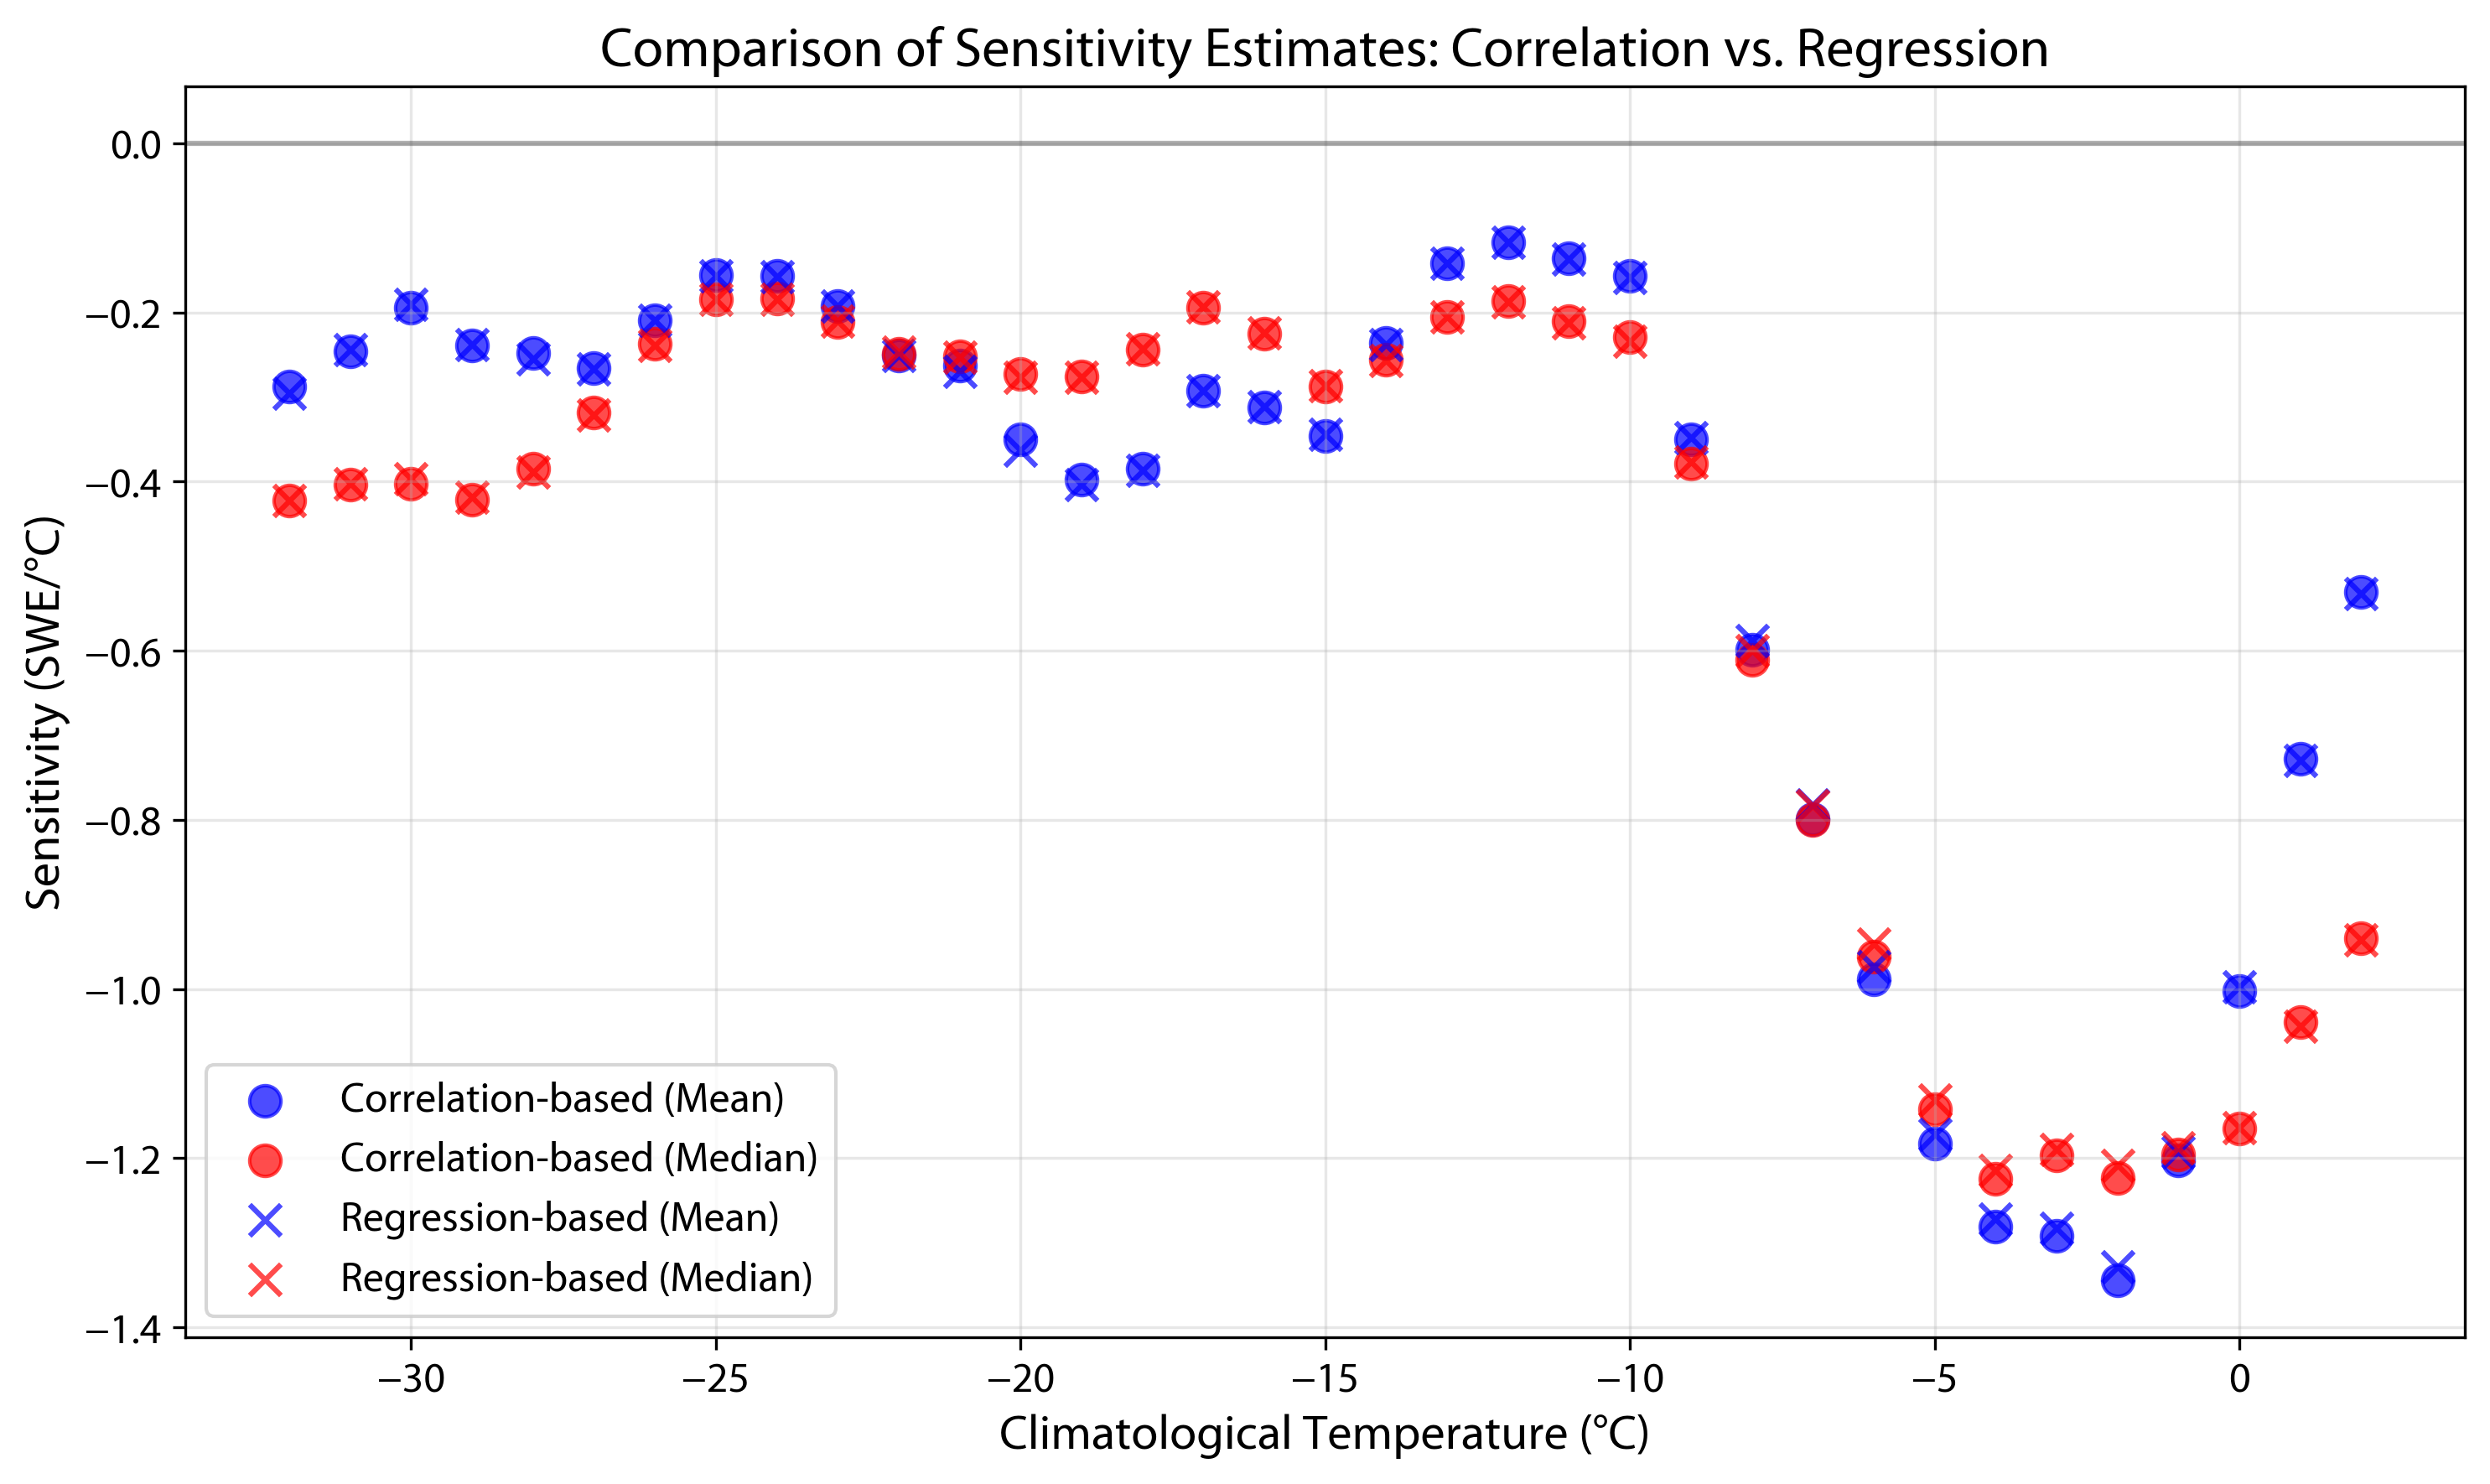

In [7]:
# Double check sensitivity using regression models
import statsmodels.api as sm

# Initialize arrays to store regression coefficients and p-values
reg_coef_mean = np.zeros((len(clim_range), 3))  # [climatology, coefficient, p-value]
reg_coef_median = np.zeros((len(clim_range), 3))  # [climatology, coefficient, p-value]

# Loop through climatology values
for i, clim_val in enumerate(clim_range):
    # Find pixels with climatology within the window
    mask = (comp_gridded[:, 5] >= clim_val - window_size) & (comp_gridded[:, 5] <= clim_val + window_size)
    
    if np.sum(mask) > 5:  # Ensure we have enough data points for regression
        # Extract data for this climatology window
        X_swe = comp_gridded[mask, 0]  # SWE trends (dependent variable)
        X_temp_mean = comp_gridded[mask, 1]  # Mean temperature trends
        X_temp_median = comp_gridded[mask, 2]  # Median temperature trends
        X_clim = comp_gridded[mask, 5]  # Climatology
        
        # Regression for mean temperature trend
        # Add constant to predictors
        X_mean = sm.add_constant(np.column_stack((X_temp_mean, X_clim)))
        # Fit regression model
        model_mean = sm.OLS(X_swe, X_mean).fit()
        # Store coefficient and p-value for temperature trend
        reg_coef_mean[i, 0] = clim_val
        reg_coef_mean[i, 1] = model_mean.params[1]  # Coefficient for temperature trend
        reg_coef_mean[i, 2] = model_mean.pvalues[1]  # p-value for temperature trend
        
        # Regression for median temperature trend
        X_median = sm.add_constant(np.column_stack((X_temp_median, X_clim)))
        model_median = sm.OLS(X_swe, X_median).fit()
        reg_coef_median[i, 0] = clim_val
        reg_coef_median[i, 1] = model_median.params[1]  # Coefficient for temperature trend
        reg_coef_median[i, 2] = model_median.pvalues[1]  # p-value for temperature trend
    else:
        reg_coef_mean[i, :] = [clim_val, np.nan, np.nan]
        reg_coef_median[i, :] = [clim_val, np.nan, np.nan]

# Remove rows with NaN values
valid_reg_mean = ~np.isnan(reg_coef_mean[:, 1])
valid_reg_median = ~np.isnan(reg_coef_median[:, 1])

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), gridspec_kw={'height_ratios': [2, 1]})

# Top panel: Regression coefficients
ax1.scatter(reg_coef_mean[valid_reg_mean, 0], reg_coef_mean[valid_reg_mean, 1], 
           label='Mean Temperature Trend', alpha=0.7, color='blue', s=100)
ax1.scatter(reg_coef_median[valid_reg_median, 0], reg_coef_median[valid_reg_median, 1], 
           label='Median Temperature Trend', alpha=0.7, color='red', s=100)

# Highlight significant points (p < 0.05)
significant_reg_mean = (reg_coef_mean[:, 2] < 0.05) & valid_reg_mean
significant_reg_median = (reg_coef_median[:, 2] < 0.05) & valid_reg_median

ax1.scatter(reg_coef_mean[significant_reg_mean, 0], reg_coef_mean[significant_reg_mean, 1], 
           color='black', s=100, facecolors='none', linewidth=1.5, 
           label='p < 0.05')
ax1.scatter(reg_coef_median[significant_reg_median, 0], reg_coef_median[significant_reg_median, 1], 
           color='black', s=100, facecolors='none', linewidth=1.5)

ax1.set_xlabel('Climatological Temperature (°C)', fontsize=14)
ax1.set_ylabel('Regression Coefficient (SWE/°C)', fontsize=14)
ax1.set_title('Sensitivity of SWE Trends to Temperature Trends from Regression Models', fontsize=16)
ax1.legend(fontsize=12)
ax1.grid(True, alpha=0.3)
ax1.axhline(y=0, color='k', linestyle='-', alpha=0.3)
ax1.tick_params(axis='both', which='major', labelsize=12)

# Bottom panel: Number of pixels (same as before)
ax2.bar(clim_range, pixel_counts, width=0.8, alpha=0.7, color='green')
ax2.set_xlabel('Climatological Temperature (°C)', fontsize=14)
ax2.set_ylabel('Number of Pixels', fontsize=14)
ax2.set_title('Number of Pixels Used for Regression Analysis', fontsize=16)
ax2.grid(True, alpha=0.3, axis='y')
ax2.tick_params(axis='both', which='major', labelsize=12)

plt.tight_layout()
plt.show()

# Compare correlation-based sensitivity with regression coefficients
fig, ax = plt.subplots(figsize=(10, 6))

# Plot correlation-based sensitivity
ax.scatter(sens_mean[valid_mean, 0], sens_mean[valid_mean, 1], 
          label='Correlation-based (Mean)', alpha=0.7, color='blue', marker='o', s=80)
ax.scatter(sens_median[valid_median, 0], sens_median[valid_median, 1], 
          label='Correlation-based (Median)', alpha=0.7, color='red', marker='o', s=80)

# Plot regression coefficients
ax.scatter(reg_coef_mean[valid_reg_mean, 0], reg_coef_mean[valid_reg_mean, 1], 
          label='Regression-based (Mean)', alpha=0.7, color='blue', marker='x', s=80)
ax.scatter(reg_coef_median[valid_reg_median, 0], reg_coef_median[valid_reg_median, 1], 
          label='Regression-based (Median)', alpha=0.7, color='red', marker='x', s=80)

ax.set_xlabel('Climatological Temperature (°C)', fontsize=14)
ax.set_ylabel('Sensitivity (SWE/°C)', fontsize=14)
ax.set_title('Comparison of Sensitivity Estimates: Correlation vs. Regression', fontsize=16)
ax.legend(fontsize=12)
ax.grid(True, alpha=0.3)
ax.axhline(y=0, color='k', linestyle='-', alpha=0.3)
ax.tick_params(axis='both', which='major', labelsize=12)

plt.tight_layout()
plt.show()


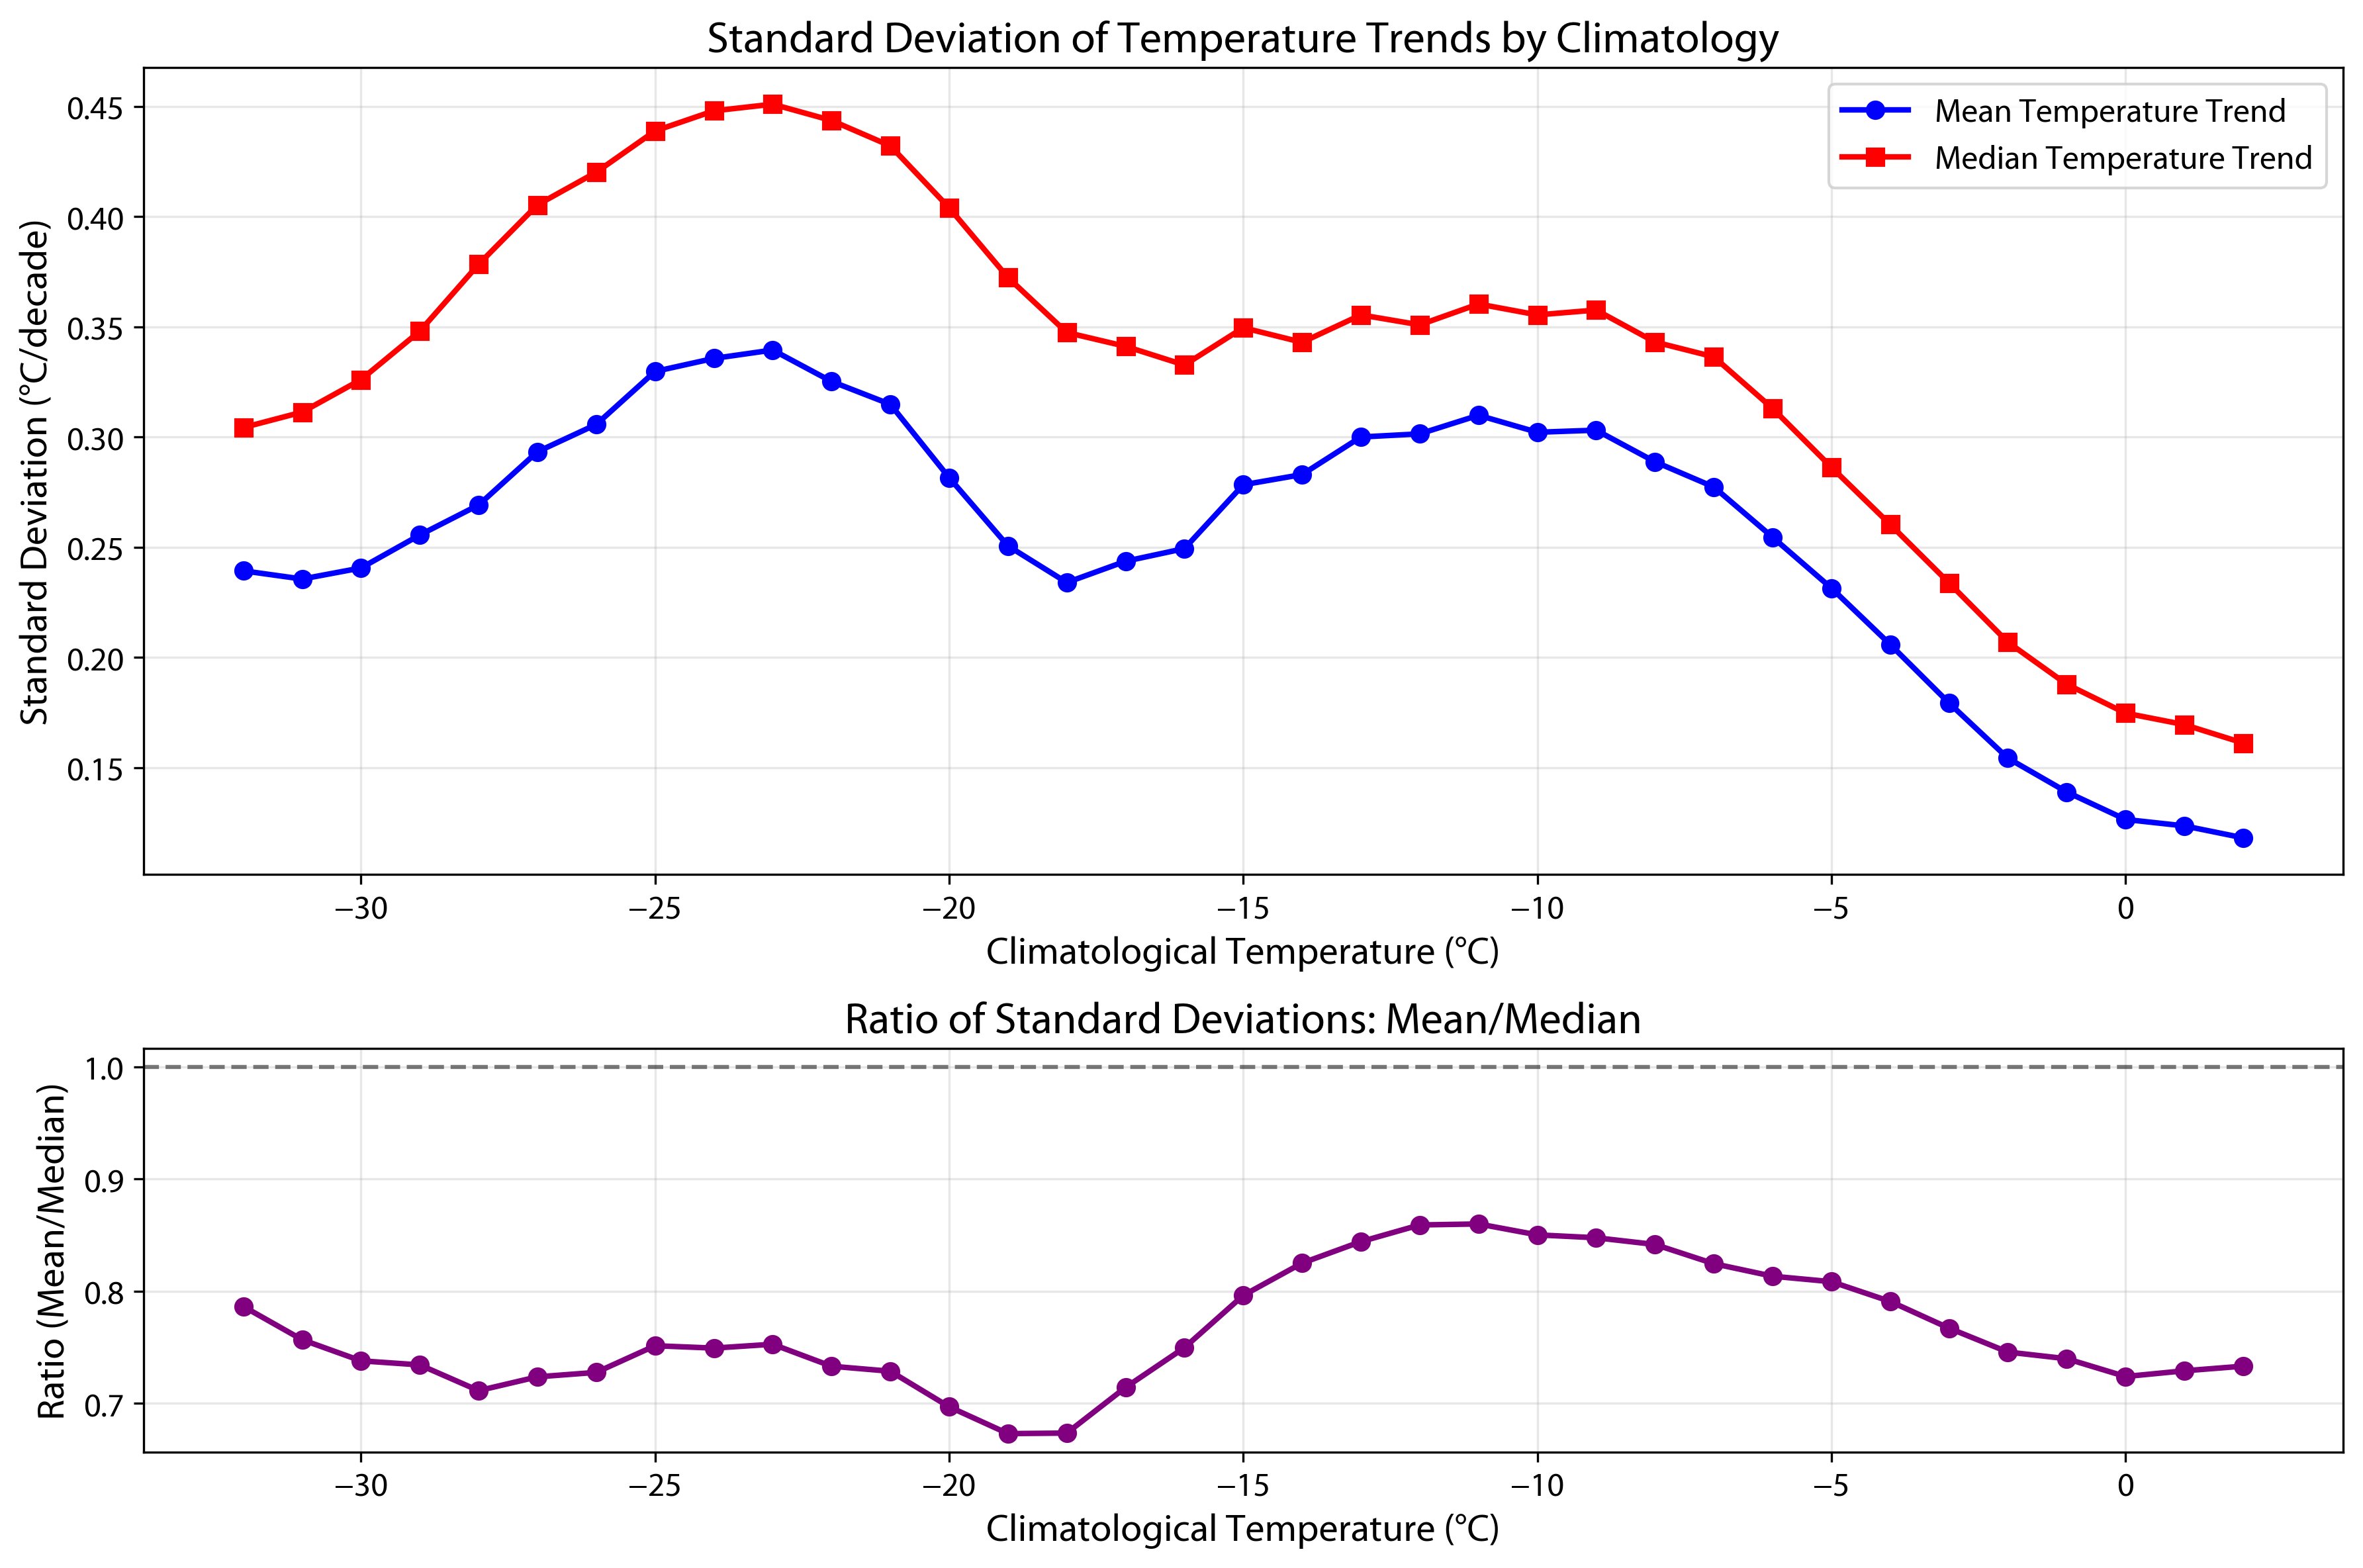

In [8]:
# Compare standard deviations of mean and median temperature trends
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), gridspec_kw={'height_ratios': [2, 1]})

# Initialize arrays to store standard deviations
std_mean_temp = np.zeros((len(clim_range), 2))  # [climatology, std_dev]
std_median_temp = np.zeros((len(clim_range), 2))  # [climatology, std_dev]

# Calculate standard deviations for each climatology window
for i, clim_val in enumerate(clim_range):
    # Find pixels with climatology within the window
    mask = (comp_gridded[:, 5] >= clim_val - window_size) & (comp_gridded[:, 5] <= clim_val + window_size)
    
    if np.sum(mask) > 5:  # Ensure we have enough data points
        # Extract mean and median temperature trends
        mean_temp_trends = comp_gridded[mask, 1]
        median_temp_trends = comp_gridded[mask, 2]
        
        # Calculate standard deviations
        std_mean_temp[i, 0] = clim_val
        std_mean_temp[i, 1] = np.std(mean_temp_trends)
        
        std_median_temp[i, 0] = clim_val
        std_median_temp[i, 1] = np.std(median_temp_trends)
    else:
        std_mean_temp[i, 0] = clim_val
        std_mean_temp[i, 1] = np.nan
        
        std_median_temp[i, 0] = clim_val
        std_median_temp[i, 1] = np.nan

# Remove rows with NaN values
valid_std_mean = ~np.isnan(std_mean_temp[:, 1])
valid_std_median = ~np.isnan(std_median_temp[:, 1])

# Top panel: Standard deviations
ax1.plot(std_mean_temp[valid_std_mean, 0], std_mean_temp[valid_std_mean, 1], 
        label='Mean Temperature Trend', color='blue', marker='o', linewidth=2)
ax1.plot(std_median_temp[valid_std_median, 0], std_median_temp[valid_std_median, 1], 
        label='Median Temperature Trend', color='red', marker='s', linewidth=2)

ax1.set_xlabel('Climatological Temperature (°C)', fontsize=14)
ax1.set_ylabel('Standard Deviation (°C/decade)', fontsize=14)
ax1.set_title('Standard Deviation of Temperature Trends by Climatology', fontsize=16)
ax1.legend(fontsize=12)
ax1.grid(True, alpha=0.3)
ax1.tick_params(axis='both', which='major', labelsize=12)

# Bottom panel: Ratio of standard deviations (mean/median)
ratio = std_mean_temp[valid_std_mean, 1] / std_median_temp[valid_std_median, 1]
ax2.plot(std_mean_temp[valid_std_mean, 0], ratio, color='purple', marker='o', linewidth=2)
ax2.axhline(y=1, color='k', linestyle='--', alpha=0.5)

ax2.set_xlabel('Climatological Temperature (°C)', fontsize=14)
ax2.set_ylabel('Ratio (Mean/Median)', fontsize=14)
ax2.set_title('Ratio of Standard Deviations: Mean/Median', fontsize=16)
ax2.grid(True, alpha=0.3)
ax2.tick_params(axis='both', which='major', labelsize=12)

plt.tight_layout()
plt.show()



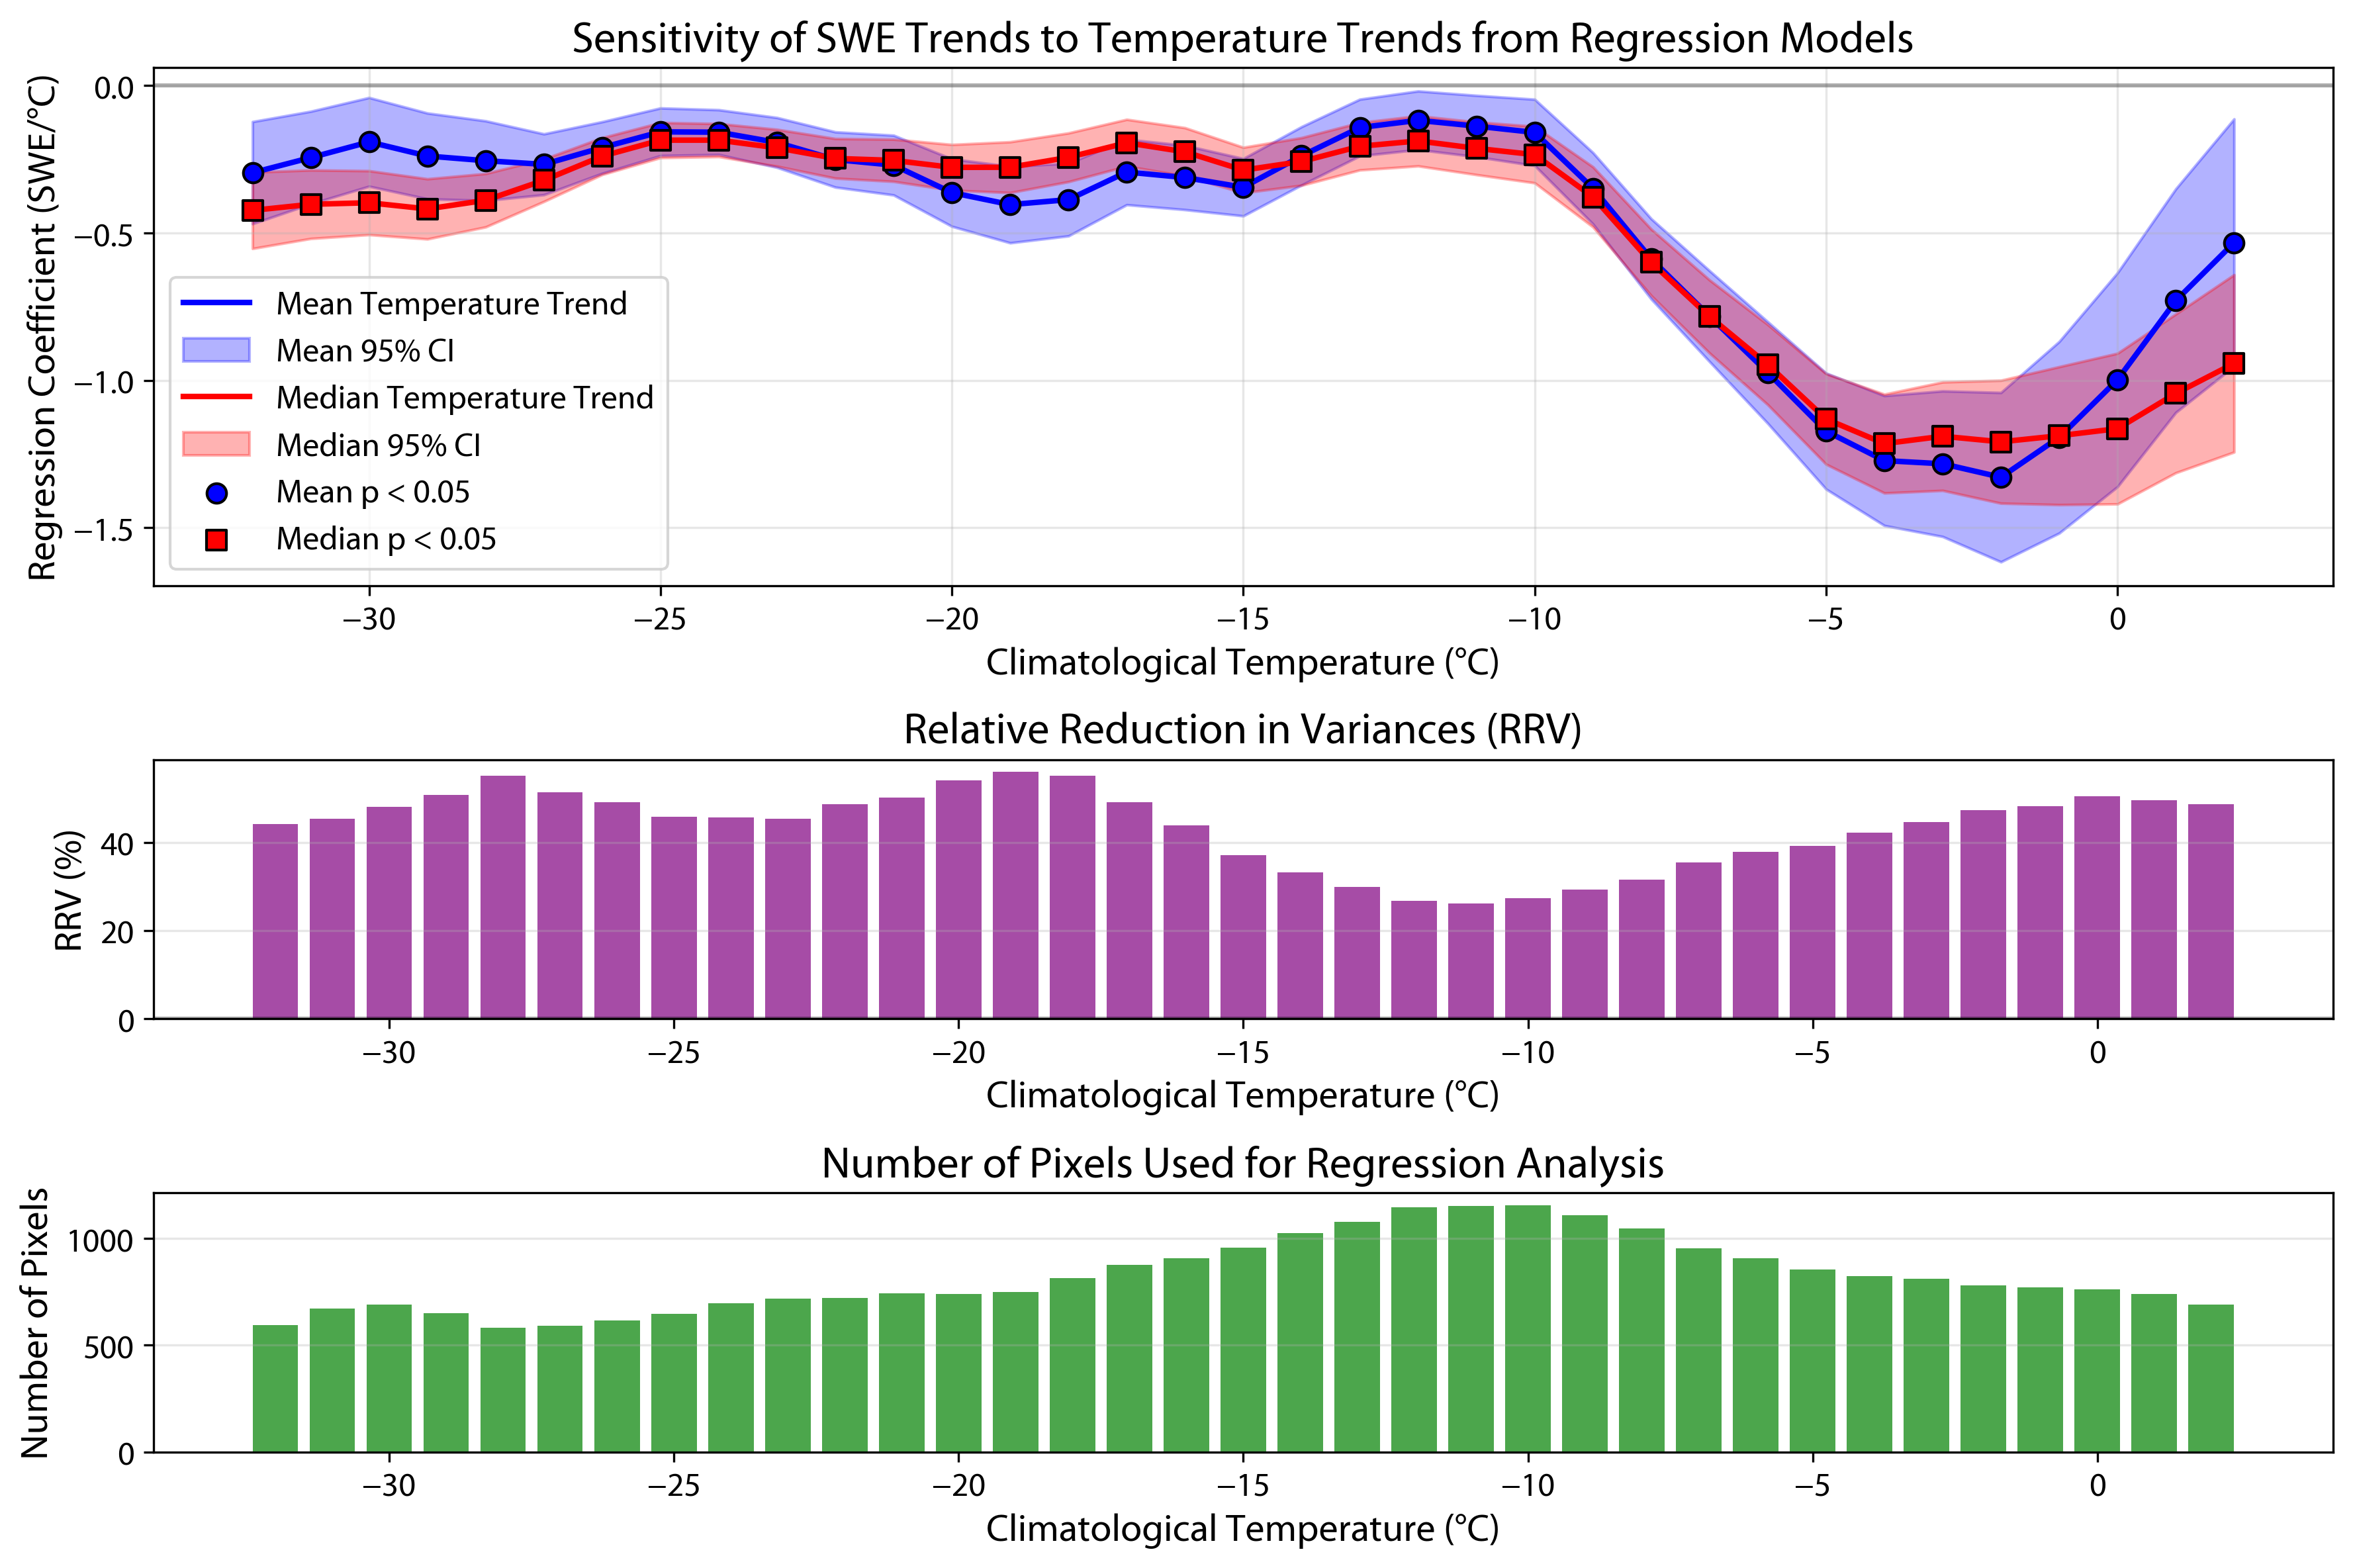

In [23]:
# Double check sensitivity using regression models
import statsmodels.api as sm

# Initialize arrays to store regression coefficients and p-values
reg_coef_mean = np.zeros((len(clim_range), 3))  # [climatology, coefficient, p-value]
reg_coef_median = np.zeros((len(clim_range), 3))  # [climatology, coefficient, p-value]
reg_stderr_mean = np.zeros((len(clim_range), 2))  # [climatology, standard error]
reg_stderr_median = np.zeros((len(clim_range), 2))  # [climatology, standard error]

# Loop through climatology values
for i, clim_val in enumerate(clim_range):
    # Find pixels with climatology within the window
    mask = (comp_gridded[:, 5] >= clim_val - window_size) & (comp_gridded[:, 5] <= clim_val + window_size)
    
    if np.sum(mask) > 5:  # Ensure we have enough data points for regression
        # Extract data for this climatology window
        X_swe = comp_gridded[mask, 0]  # SWE trends (dependent variable)
        X_temp_mean = comp_gridded[mask, 1]  # Mean temperature trends
        X_temp_median = comp_gridded[mask, 2]  # Median temperature trends
        X_clim = comp_gridded[mask, 5]  # Climatology
        
        # Regression for mean temperature trend
        # Add constant to predictors
        X_mean = sm.add_constant(np.column_stack((X_temp_mean, X_clim)))
        # Fit regression model
        model_mean = sm.OLS(X_swe, X_mean).fit()
        # Store coefficient and p-value for temperature trend
        reg_coef_mean[i, 0] = clim_val
        reg_coef_mean[i, 1] = model_mean.params[1]  # Coefficient for temperature trend
        reg_coef_mean[i, 2] = model_mean.pvalues[1]  # p-value for temperature trend
        reg_stderr_mean[i, 0] = clim_val
        reg_stderr_mean[i, 1] = model_mean.bse[1]  # Standard error for temperature trend
        
        # Regression for median temperature trend
        X_median = sm.add_constant(np.column_stack((X_temp_median, X_clim)))
        model_median = sm.OLS(X_swe, X_median).fit()
        reg_coef_median[i, 0] = clim_val
        reg_coef_median[i, 1] = model_median.params[1]  # Coefficient for temperature trend
        reg_coef_median[i, 2] = model_median.pvalues[1]  # p-value for temperature trend
        reg_stderr_median[i, 0] = clim_val
        reg_stderr_median[i, 1] = model_median.bse[1]  # Standard error for temperature trend
    else:
        reg_coef_mean[i, :] = [clim_val, np.nan, np.nan]
        reg_coef_median[i, :] = [clim_val, np.nan, np.nan]
        reg_stderr_mean[i, :] = [clim_val, np.nan]
        reg_stderr_median[i, :] = [clim_val, np.nan]

# Remove rows with NaN values
valid_reg_mean = ~np.isnan(reg_coef_mean[:, 1])
valid_reg_median = ~np.isnan(reg_coef_median[:, 1])

# Calculate RRV (Relative Reduction in Variances)
rrv = np.zeros(len(clim_range))
for i in range(len(clim_range)):
    if valid_reg_mean[i] and valid_reg_median[i]:
        var_mean = reg_stderr_mean[i, 1]**2  # Variance of mean temperature slope
        var_median = reg_stderr_median[i, 1]**2  # Variance of median temperature slope
        rrv[i] = (1 - var_median / var_mean) * 100  # RRV in percentage
    else:
        rrv[i] = np.nan

# Create figure with three subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 8), gridspec_kw={'height_ratios': [2, 1, 1]})

# Top panel: Regression coefficients with 95% confidence interval
# Plot mean temperature trend with 95% confidence interval
ax1.plot(reg_coef_mean[valid_reg_mean, 0], reg_coef_mean[valid_reg_mean, 1], 
         color='blue', linewidth=2, label='Mean Temperature Trend')
ax1.fill_between(reg_coef_mean[valid_reg_mean, 0], 
                 reg_coef_mean[valid_reg_mean, 1] - 1.96 * reg_stderr_mean[valid_reg_mean, 1],
                 reg_coef_mean[valid_reg_mean, 1] + 1.96 * reg_stderr_mean[valid_reg_mean, 1],
                 alpha=0.3, color='blue', label='Mean 95% CI')

# Plot median temperature trend with 95% confidence interval
ax1.plot(reg_coef_median[valid_reg_median, 0], reg_coef_median[valid_reg_median, 1], 
         color='red', linewidth=2, label='Median Temperature Trend')
ax1.fill_between(reg_coef_median[valid_reg_median, 0], 
                 reg_coef_median[valid_reg_median, 1] - 1.96 * reg_stderr_median[valid_reg_median, 1],
                 reg_coef_median[valid_reg_median, 1] + 1.96 * reg_stderr_median[valid_reg_median, 1],
                 alpha=0.3, color='red', label='Median 95% CI')

# Highlight significant points (p < 0.05)
significant_reg_mean = (reg_coef_mean[:, 2] < 0.05) & valid_reg_mean
significant_reg_median = (reg_coef_median[:, 2] < 0.05) & valid_reg_median

ax1.scatter(reg_coef_mean[significant_reg_mean, 0], reg_coef_mean[significant_reg_mean, 1], 
           color='blue', s=50, marker='o', edgecolors='black', linewidth=1, 
           label='Mean p < 0.05', zorder=5)
ax1.scatter(reg_coef_median[significant_reg_median, 0], reg_coef_median[significant_reg_median, 1], 
           color='red', s=50, marker='s', edgecolors='black', linewidth=1,
           label='Median p < 0.05', zorder=5)

ax1.set_xlabel('Climatological Temperature (°C)', fontsize=14)
ax1.set_ylabel('Regression Coefficient (SWE/°C)', fontsize=14)
ax1.set_title('Sensitivity of SWE Trends to Temperature Trends from Regression Models', fontsize=16)
ax1.legend(fontsize=12)
ax1.grid(True, alpha=0.3)
ax1.axhline(y=0, color='k', linestyle='-', alpha=0.3)
ax1.tick_params(axis='both', which='major', labelsize=12)

# Middle panel: RRV (Relative Reduction in Variances)
valid_rrv = ~np.isnan(rrv)
ax2.bar(clim_range[valid_rrv], rrv[valid_rrv], width=0.8, alpha=0.7, color='purple')
ax2.axhline(y=0, color='k', linestyle='-', alpha=0.3)
ax2.set_xlabel('Climatological Temperature (°C)', fontsize=14)
ax2.set_ylabel('RRV (%)', fontsize=14)
ax2.set_title('Relative Reduction in Variances (RRV)', fontsize=16)
ax2.grid(True, alpha=0.3, axis='y')
ax2.tick_params(axis='both', which='major', labelsize=12)

# Bottom panel: Number of pixels
ax3.bar(clim_range, pixel_counts, width=0.8, alpha=0.7, color='green')
ax3.set_xlabel('Climatological Temperature (°C)', fontsize=14)
ax3.set_ylabel('Number of Pixels', fontsize=14)
ax3.set_title('Number of Pixels Used for Regression Analysis', fontsize=16)
ax3.grid(True, alpha=0.3, axis='y')
ax3.tick_params(axis='both', which='major', labelsize=12)

plt.tight_layout()
plt.show()